## Imports and Configuration

In [1]:
import os
import datetime
import wandb

import torch

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary

from config.load_configuration import load_configuration
from data.datamodule import ECG_DataModule
from model.model import UNET_1D

#### Loading configuration

This notebook loads configuration settings using the `load_configuration` function from the `config.load_configuration` module. The configuration is stored in the `config` variable.

In [2]:
config = load_configuration()

PC Name: DESKTOP-LUKAS
Loaded configuration from config/config_lukas.yaml


#### Logging in to Weights & Biases (wandb)

Before starting any experiment tracking, ensure you are logged in to your Weights & Biases (wandb) account. This enables automatic logging of metrics, model checkpoints, and experiment configurations. The following code logs you in to wandb:

```python
wandb.login()
```
If you are running this for the first time, you may be prompted to enter your API key.

In [3]:
wandb.login()

wandb: Currently logged in as: lukas-pelz (HKA-EKG-Signalverarbeitung) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### Setting Seeds for Reproducibility

To ensure comparable and reproducible results, we set the random seed using the `seed_everything` function from PyTorch Lightning. This helps in achieving consistent behavior across multiple runs of the notebook.

In [4]:
pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # disable oneDNN optimizations for reproducibility
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Seed set to 42


#### Checking for GPU Devices

In this step, we check for the availability of GPU devices and print the device currently being used by PyTorch. This ensures that the computations are performed on the most efficient hardware available.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*40)
print(f"Torch Version      : {torch.__version__}")
print(f"Selected Device    : {device}")
if device.type == 'cuda':
    print(f"CUDA Version       : {torch.version.cuda}")
    print(f"Device Name        : {torch.cuda.get_device_name(0)}")
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"Memory Usage       : Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB")
    torch.set_float32_matmul_precision('high')
else:
    print("CUDA not available, using CPU.")
print("="*40)

Torch Version      : 2.7.0+cu128
Selected Device    : cuda
CUDA Version       : 12.8
Device Name        : NVIDIA GeForce RTX 5060 Ti
Memory Usage       : Allocated: 0.00 GB | Reserved: 0.00 GB


#### Initializing the Data Module

The `ECG_DataModule` is initialized using the data path, batch size, and feature list from the configuration. This prepares the data for training and validation.

In [6]:
config['data_cols'] = ['II']

dm = ECG_DataModule(
    data_dir=config['path_to_data'],
    batch_size=config['batch_size'],
    # num_workers=0,
    # persistent_workers=False,
    num_workers=config['num_workers'],
    persistent_workers=config['persistent_workers'],
    feature_list=config['feature_list'],
    data_cols=config['data_cols']
)
dm.setup()
dm.train_dataset.__getitem__(0)  # Warm up dataset (for reproducibility when using num_workers > 0)
print(dm.train_dataset.__getitem__(0))

(tensor([[-3.0247e-02, -2.3617e-02, -1.8016e-02, -1.3541e-02, -1.0114e-02,
         -7.5435e-03, -5.5755e-03, -3.9308e-03, -2.3107e-03, -3.9709e-04,
          2.1348e-03,  5.5767e-03,  1.0123e-02,  1.5799e-02,  2.2405e-02,
          2.9514e-02,  3.6546e-02,  4.2892e-02,  4.8063e-02,  5.1802e-02,
          5.4116e-02,  5.5226e-02,  5.5463e-02,  5.5165e-02,  5.4605e-02,
          5.3966e-02,  5.3349e-02,  5.2798e-02,  5.2338e-02,  5.1989e-02,
          5.1764e-02,  5.1652e-02,  5.1607e-02,  5.1548e-02,  5.1377e-02,
          5.0990e-02,  5.0307e-02,  4.9281e-02,  4.7917e-02,  4.6270e-02,
          4.4443e-02,  4.2578e-02,  4.0851e-02,  3.9460e-02,  3.8610e-02,
          3.8463e-02,  3.9071e-02,  4.0318e-02,  4.1887e-02,  4.3303e-02,
          4.4040e-02,  4.3689e-02,  4.2118e-02,  3.9557e-02,  3.6559e-02,
          3.3857e-02,  3.2157e-02,  3.1918e-02,  3.3175e-02,  3.5481e-02,
          3.8010e-02,  3.9810e-02,  4.0113e-02,  3.8551e-02,  3.5204e-02,
          3.0495e-02,  2.5018e-02,  1

#### Creating the Model

In this step, we will define the model architecture and print its summary using the `ModelSummary` utility from PyTorch Lightning. This provides an overview of the model's layers, parameters, and structure.

In [7]:
model = UNET_1D(
    in_channels=len(config['data_cols']), 
    layer_n=512, 
    out_channels=len(config['feature_list']), 
    kernel_size=5
)
print(ModelSummary(model, max_depth=-1))  
print(type(model).__name__)

    | Name                                            | Type                  | Params | Mode  | In sizes      | Out sizes    
------------------------------------------------------------------------------------------------------------------------------------
0   | criterion                                       | BCEWithLogitsLoss     | 0      | train | ?             | ?            
1   | train_jaccard                                   | BinaryJaccardIndex    | 0      | train | ?             | ?            
2   | val_jaccard                                     | BinaryJaccardIndex    | 0      | train | ?             | ?            
3   | test_jaccard                                    | BinaryJaccardIndex    | 0      | train | ?             | ?            
4   | multi_tolerance_metrics                         | MultiToleranceWrapper | 0      | train | ?             | ?            
5   | multi_tolerance_metrics.metrics                 | ModuleDict            | 0      | train | ?       

In [8]:
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
print(f"Current Time       : {current_time}")

# Initialize wandb logger (https://wandb.ai/HKA-EKG-Signalverarbeitung)
wandb_logger = WandbLogger(
    project=config['wandb_project_name'],
    name=f"{config['wandb_experiment_name']}_{type(model).__name__}_{current_time}",
    config={
        'model': type(model).__name__,
        'dataset': type(dm).__name__,
        'batch_size': config['batch_size'],
        'max_epochs': config['max_epochs'],
        'learning_rate': config['learning_rate']
    }
)

# Initialize Trainer with wandb logger, using early stopping callback (https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)
trainer = Trainer(
    max_epochs=config['max_epochs'], 
    default_root_dir='model/checkpoint/', #data_directory, 
    accelerator="auto", 
    devices="auto", 
    strategy="auto",
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')], 
    logger=wandb_logger)

trainer.fit(model=model, datamodule=dm)

# Finish wandb
wandb.finish()

# Create a filename with date identifier
model_filename = f"{config['wandb_experiment_name']}_{type(model).__name__}_{current_time}.ckpt"
model.model_name = f"{config['wandb_experiment_name']}_{type(model).__name__}_{current_time}"

# Save the model's state_dict to the path specified in config
save_path = os.path.join(config['path_to_models'], model_filename)
trainer.save_checkpoint(save_path)
print(f"Model checkpoint saved as {save_path}")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Current Time       : 2025-09-17_10-40


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type                  | Params | Mode  | In sizes      | Out sizes    
-----------------------------------------------------------------------------------------------------------
0  | criterion               | BCEWithLogitsLoss     | 0      | train | ?             | ?            
1  | train_jaccard           | BinaryJaccardIndex    | 0      | train | ?             | ?            
2  | val_jaccard             | BinaryJaccardIndex    | 0      | train | ?             | ?            
3  | test_jaccard            | BinaryJaccardIndex    | 0      | train | ?             | ?            
4  | multi_tolerance_metrics | MultiToleranceWrapper | 0      | train | ?             | ?            
5  | AvgPool1D1              | AvgPool1d             | 0      | train | [1, 64, 512]  | [1, 64, 256] 
6  | AvgPool1D2              | AvgPool1d             | 0      | train | [1, 128, 256] | [1, 128, 128]
7  | AvgPool1D3              | Av

Epoch 43: 100%|██████████| 477/477 [00:40<00:00, 11.90it/s, v_num=ksy2, train_loss_step=0.0676, val_loss_step=0.0574, val_loss_epoch=0.0741, train_loss_epoch=0.0714]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▇▇▇▇▇▇▇▇▇█████
train_loss_epoch,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▄▄▃▂▂▂▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂
trainer/global_step,▁▁▁▁▁▃▃▂▄▂▂▂▂▂▂▂▂▂▂▂▇▂▂▂▂█▂▂▂▃▃▃▃▃▃▃▃▃▃▃
val_loss_epoch,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,█▆▅▅▅▃▃▂▂▂▂▃▂▂▂▂▁▁▂▂▁▁▂▁▂▂▂▂▂▁▁▂▁▁▁▂▂▂▁▂
epoch,43
train_loss_epoch,0.0714
train_loss_step,0.06765
trainer/global_step,20987
val_loss_epoch,0.07407


Model checkpoint saved as C:\Users\lukas\Documents\HKA_DEV\HKA_EKG_Signalverarbeitung_Data\models\manual_training_1_lead_UNET_1D_2025-09-17_10-40.ckpt


c:\Users\lukas\anaconda3\envs\HKA_EKG_Signalverarbeitung\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-09-17 08:56:43,988] A new study created in memory with name: Optuna_HPO_2025-09-17_08-56
  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\lukas\anaconda3\envs\HKA_EKG_Signalverarbeitung\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True


Selected leads for this trial: ['III', 'AVR', 'AVL', 'AVF', 'V2', 'V3', 'V4']
['III', 'AVR', 'AVL', 'AVF', 'V2', 'V3', 'V4']
III-AVR-AVL-AVF-V2-V3-V4


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type                  | Params | Mode  | In sizes      | Out sizes    
-----------------------------------------------------------------------------------------------------------
0  | criterion               | BCEWithLogitsLoss     | 0      | train | ?             | ?            
1  | train_jaccard           | BinaryJaccardIndex    | 0      | train | ?             | ?            
2  | val_jaccard             | BinaryJaccardIndex    | 0      | train | ?             | ?            
3  | test_jaccard            | BinaryJaccardIndex    | 0      | train | ?             | ?            
4  | multi_tolerance_metrics | MultiToleranceWrapper | 0      | train | ?             | ?            
5  | AvgPool1D1              | AvgPool1d             | 0      | train | [1, 64, 512]  | [1, 64, 256] 
6  | AvgPool1D2              | AvgPool1d             | 0      | train | [1, 128, 256] | [1, 128, 128]
7  | AvgPool1D3              | Av

Epoch 2: 100%|██████████| 954/954 [00:32<00:00, 29.68it/s, v_num=miz8, train_loss_step=0.143, val_loss_step=0.122, val_loss_epoch=0.122, train_loss_epoch=0.139]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 954/954 [00:32<00:00, 28.96it/s, v_num=miz8, train_loss_step=0.143, val_loss_step=0.122, val_loss_epoch=0.122, train_loss_epoch=0.139]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
train_loss_epoch,█▃▁
train_loss_step,█▇▇▆▆▅▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▂▁
trainer/global_step,▂▃▃▃▁▁▁▁▁▁▁▃▃▄▅▂▂▂▂▂▂▂▂▆▆▇▇▇██▂▂▂▂▂▂▂▂▂▂
val_loss_epoch,█▃▁
val_loss_step,█▇████▇█████▄▄▃▃▃▄▃▃▃▃▃▃▄▃▃▂▄▁▃▂▂▂▂▁▂▂▁▁
epoch,2
train_loss_epoch,0.1393
train_loss_step,0.11675
trainer/global_step,2861
val_loss_epoch,0.12247


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\lukas\anaconda3\envs\HKA_EKG_Signalverarbeitung\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model checkpoint saved as C:\Users\lukas\Documents\HKA_DEV\HKA_EKG_Signalverarbeitung_Data\models\type_bs16_lr1.0e-03_wd5.0e-05_optAdamW_schStepLR_acc1_leadsIII-AVR-AVL-AVF-V2-V3-V4_2025-09-17_08-56\model_best_ckpt.ckpt
Optimization finished with best validation loss: 0.12247161567211151
type_bs16_lr1.0e-03_wd5.0e-05_optAdamW_schStepLR_acc1_leadsIII-AVR-AVL-AVF-V2-V3-V4_2025-09-17_08-56
Testing DataLoader 0: 100%|██████████| 202/202 [01:26<00:00,  2.34it/s]

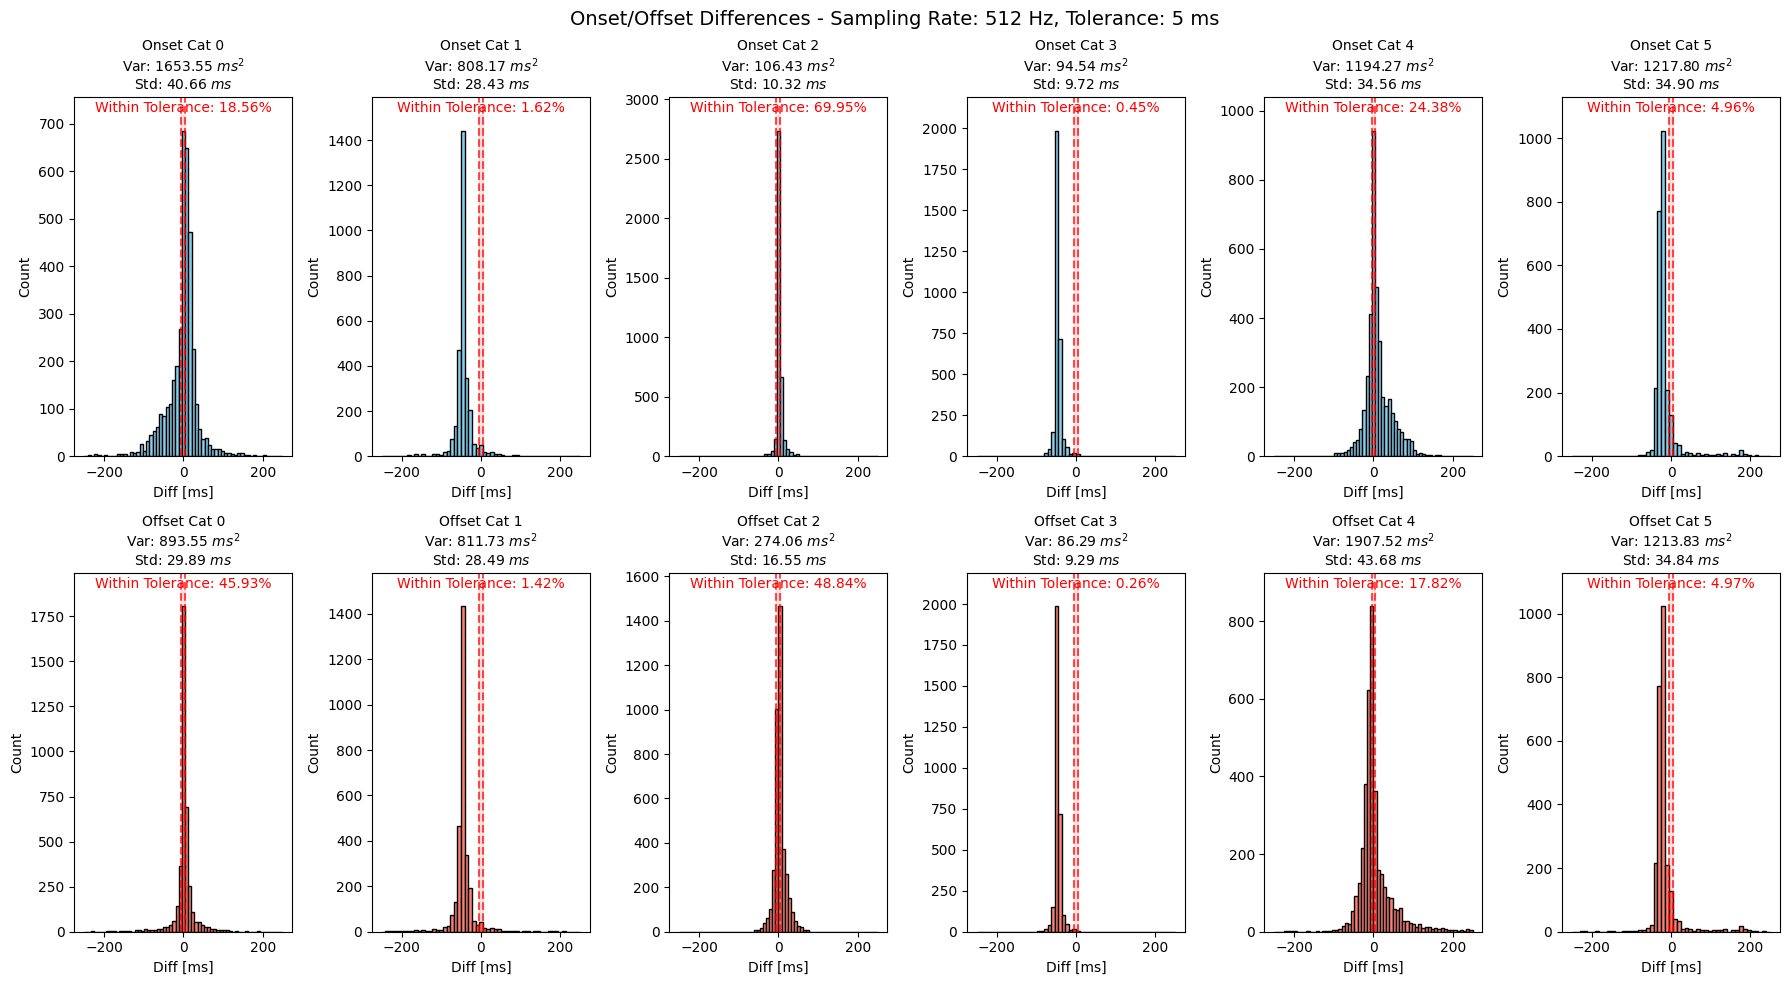

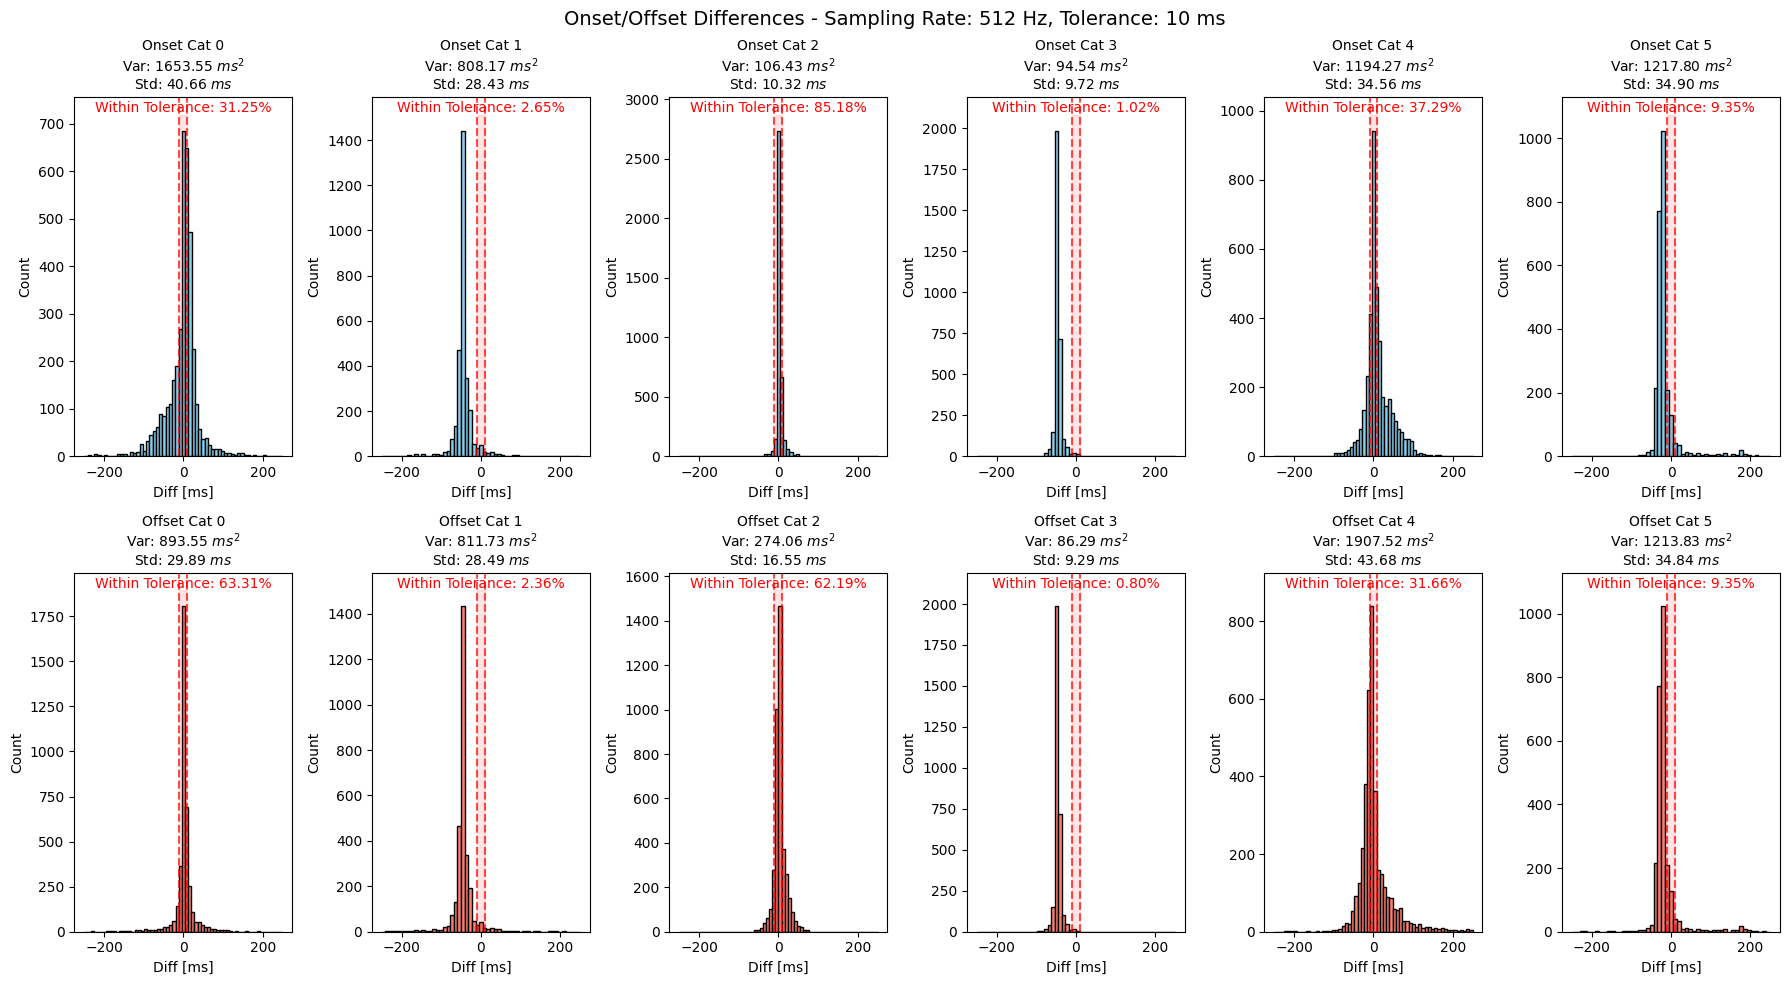

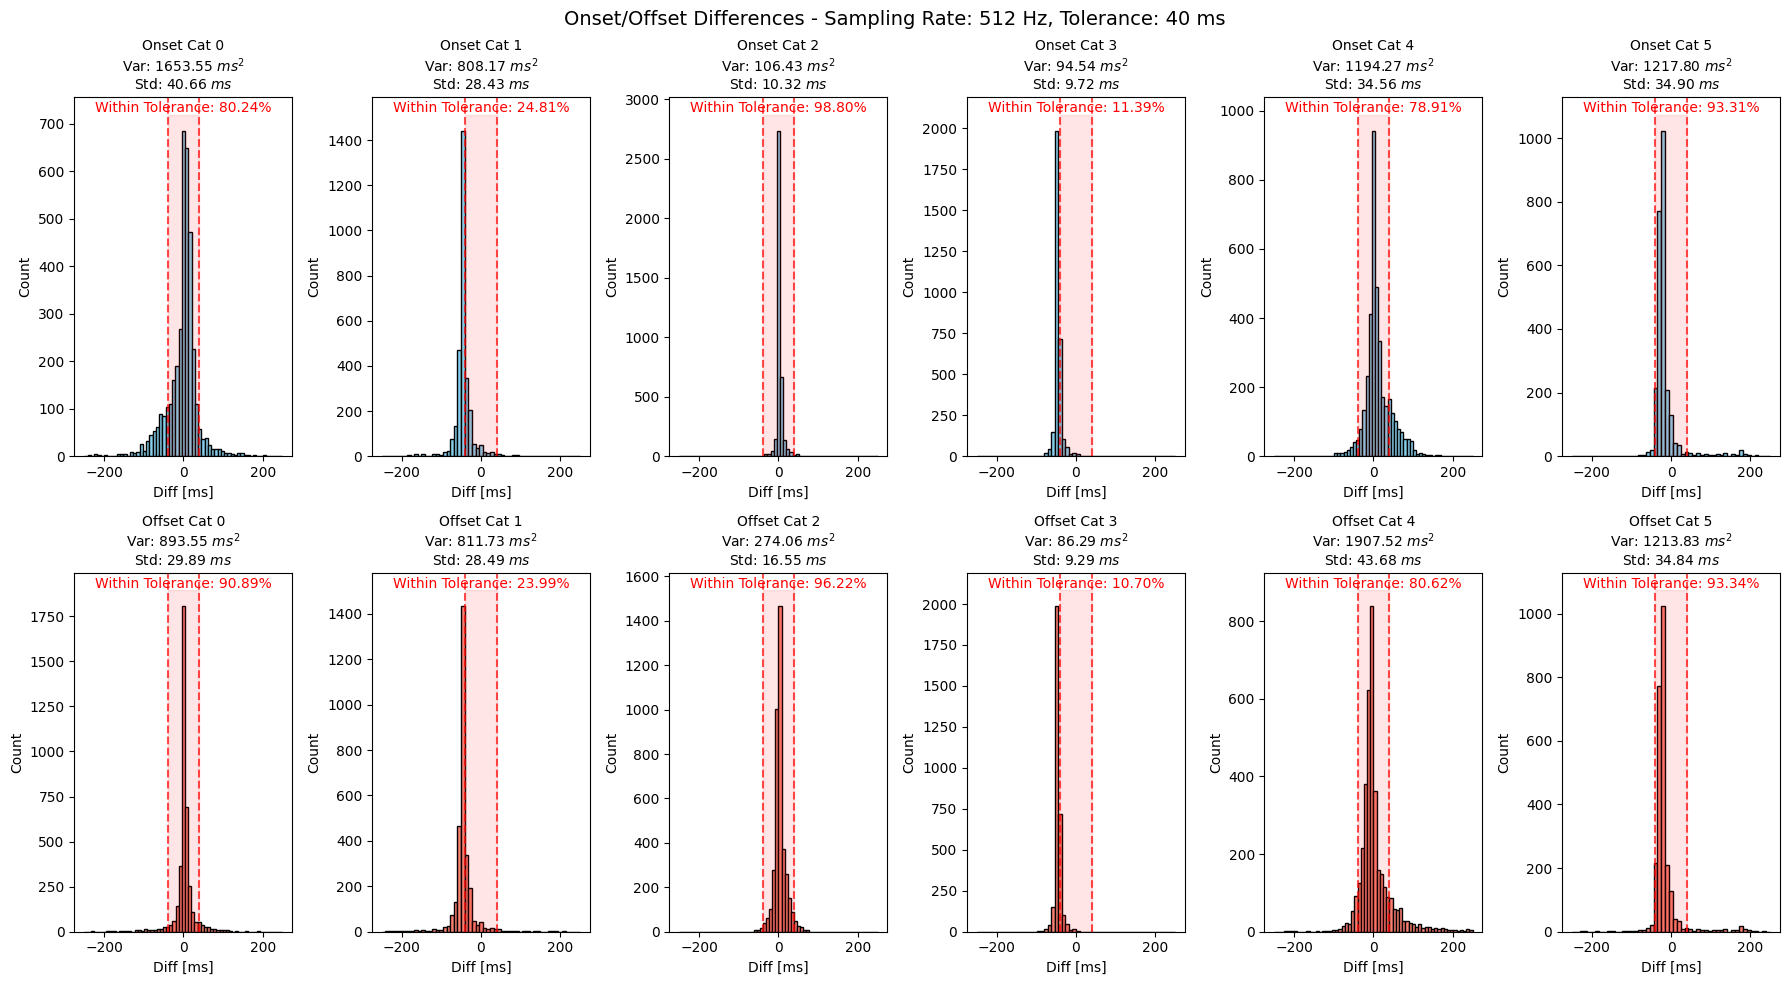

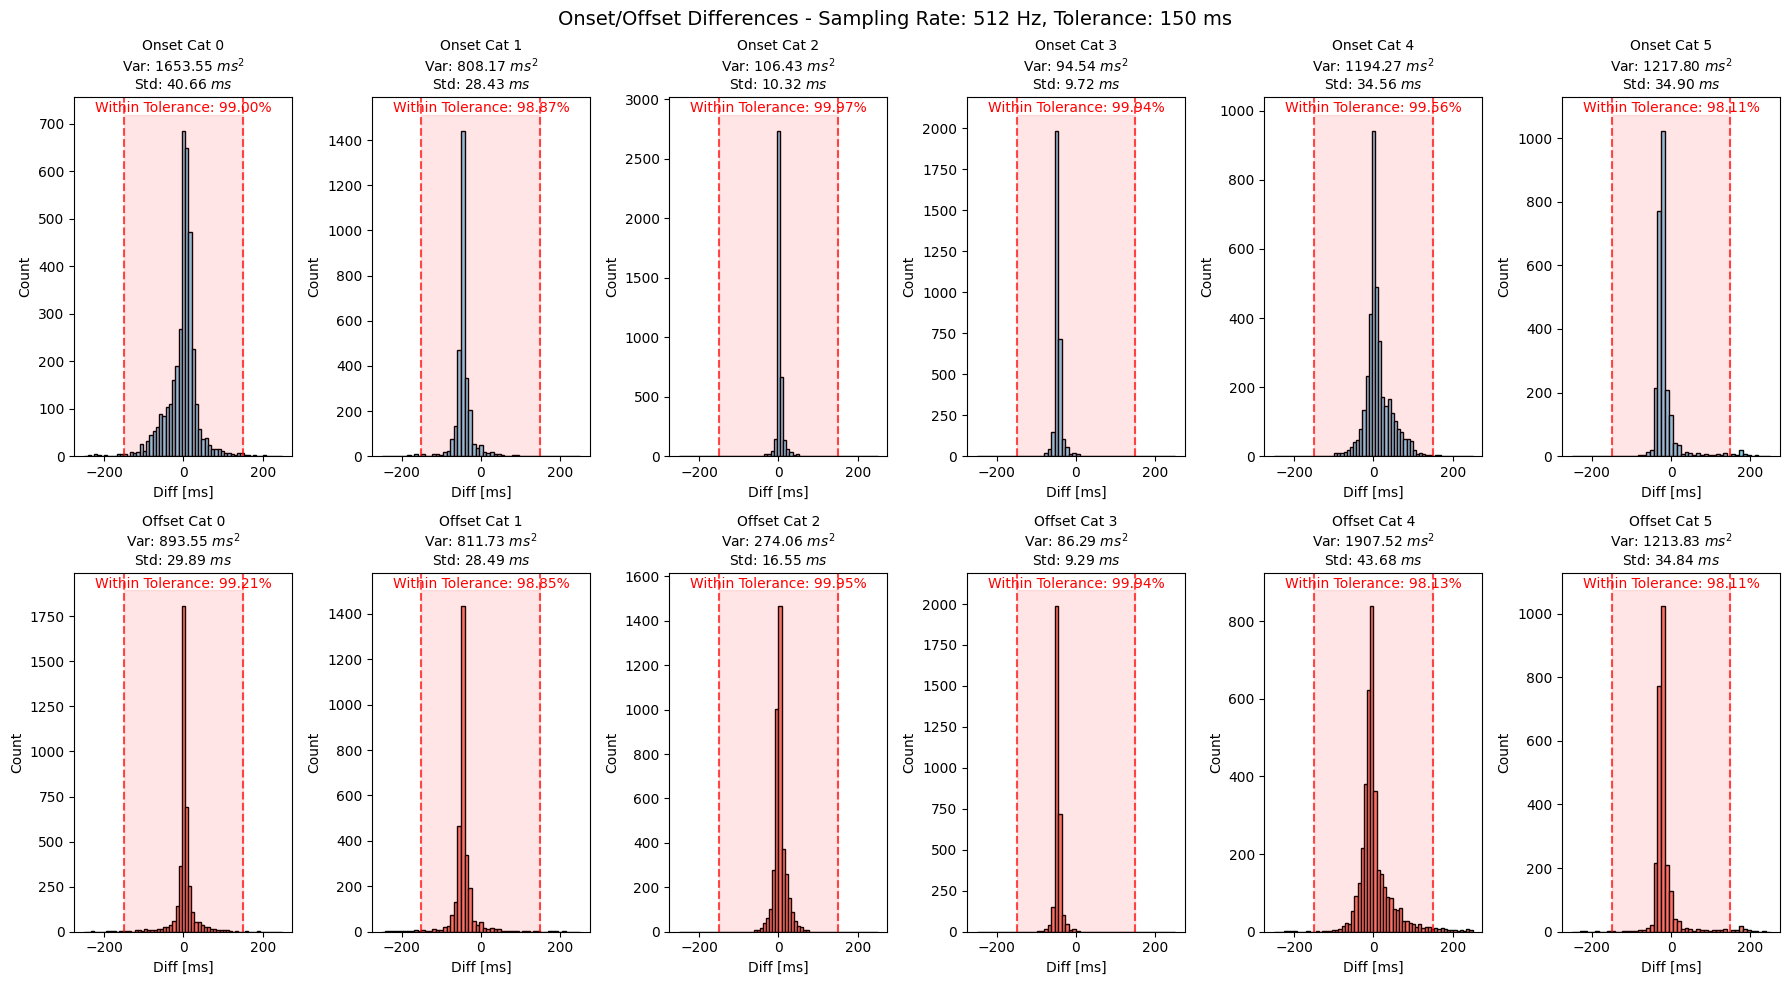

Test Epoch End
-----------------------------------
Testing DataLoader 0: 100%|██████████| 202/202 [01:31<00:00,  2.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               Test metric                             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              test_jaccard                          0.8537945747375488
             test_loss_epoch                        0.12189597636461258
     tolerance_10ms_f1_offset_global                0.6505505442619324
     tolerance_10ms_f1_onset_global                 0.6314573287963867
     tolerance_10ms_fn_offset_global                      8715.0
     tolerance_10ms_fn_onset_global                       8827.0
     tolerance_10ms_fp_offset_global                      2011.0
     tolerance_10ms_fp_onset_global                       2338.0
    tolerance_10ms_ppv

Best trial: 0. Best value: 0.122472:  20%|██        | 1/5 [03:46<15:06, 226.52s/it]c:\Users\lukas\anaconda3\envs\HKA_EKG_Signalverarbeitung\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Selected leads for this trial: ['III', 'AVF', 'V2', 'V4', 'V5']
['III', 'AVF', 'V2', 'V4', 'V5']
III-AVF-V2-V4-V5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type                  | Params | Mode  | In sizes      | Out sizes    
-----------------------------------------------------------------------------------------------------------
0  | criterion               | BCEWithLogitsLoss     | 0      | train | ?             | ?            
1  | train_jaccard           | BinaryJaccardIndex    | 0      | train | ?             | ?            
2  | val_jaccard             | BinaryJaccardIndex    | 0      | train | ?             | ?            
3  | test_jaccard            | BinaryJaccardIndex    | 0      | train | ?             | ?            
4  | multi_tolerance_metrics | MultiToleranceWrapper | 0      | train | ?             | ?            
5  | AvgPool1D1              | AvgPool1d             | 0      | train | [1, 64, 512]  | [1, 64, 256] 
6  | AvgPool1D2              | AvgPool1d             | 0      | train | [1, 128, 256] | [1, 128, 128]
7  | AvgPool1D3              | Av

Epoch 2: 100%|██████████| 239/239 [00:18<00:00, 13.28it/s, v_num=3uwr, train_loss_step=0.470, val_loss_step=0.462, val_loss_epoch=0.467, train_loss_epoch=0.475]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 239/239 [00:18<00:00, 12.73it/s, v_num=3uwr, train_loss_step=0.470, val_loss_step=0.462, val_loss_epoch=0.467, train_loss_epoch=0.475]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████████
train_loss_epoch,█▄▁
train_loss_step,█▄▄▄▄▄▃▃▄▃▃▃▃▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁
trainer/global_step,▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▃▄▄▄▅▅▆▂▂▂▂▂▂▂▆▇█▂▂▂▂▂▂▂█
val_loss_epoch,█▄▁
val_loss_step,▇▇▇▆▆█▇▆▇▇▇▇▇▆▇█▄▄▄▃▃▄▄▄▄▄▁▁▂▂▁▂▂▂▁▂▁▁▁▂
epoch,2
train_loss_epoch,0.47548
train_loss_step,0.4668
trainer/global_step,716
val_loss_epoch,0.46657


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model checkpoint saved as C:\Users\lukas\Documents\HKA_DEV\HKA_EKG_Signalverarbeitung_Data\models\type_bs64_lr1.4e-04_wd3.8e-03_optAdamW_schStepLR_acc1_leadsIII-AVF-V2-V4-V5_2025-09-17_09-00\model_best_ckpt.ckpt
Optimization finished with best validation loss: 0.46657124161720276
type_bs64_lr1.4e-04_wd3.8e-03_optAdamW_schStepLR_acc1_leadsIII-AVF-V2-V4-V5_2025-09-17_09-00
Testing DataLoader 0: 100%|██████████| 51/51 [02:36<00:00,  0.33it/s]

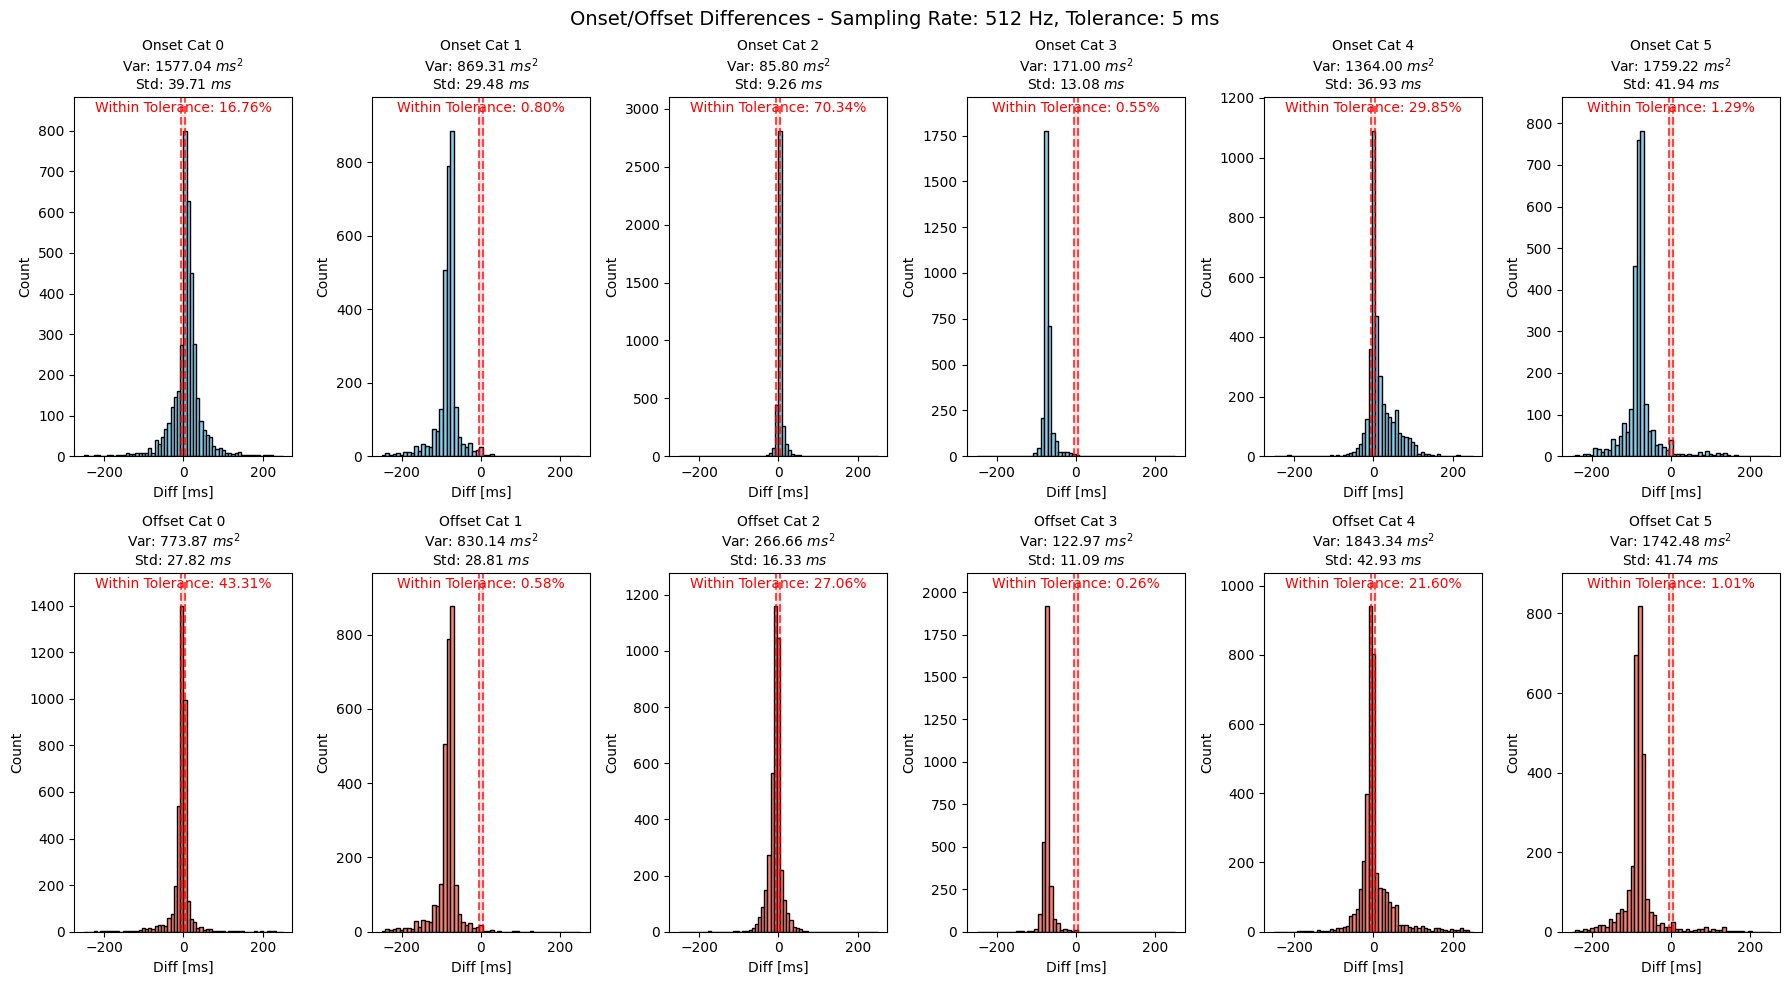

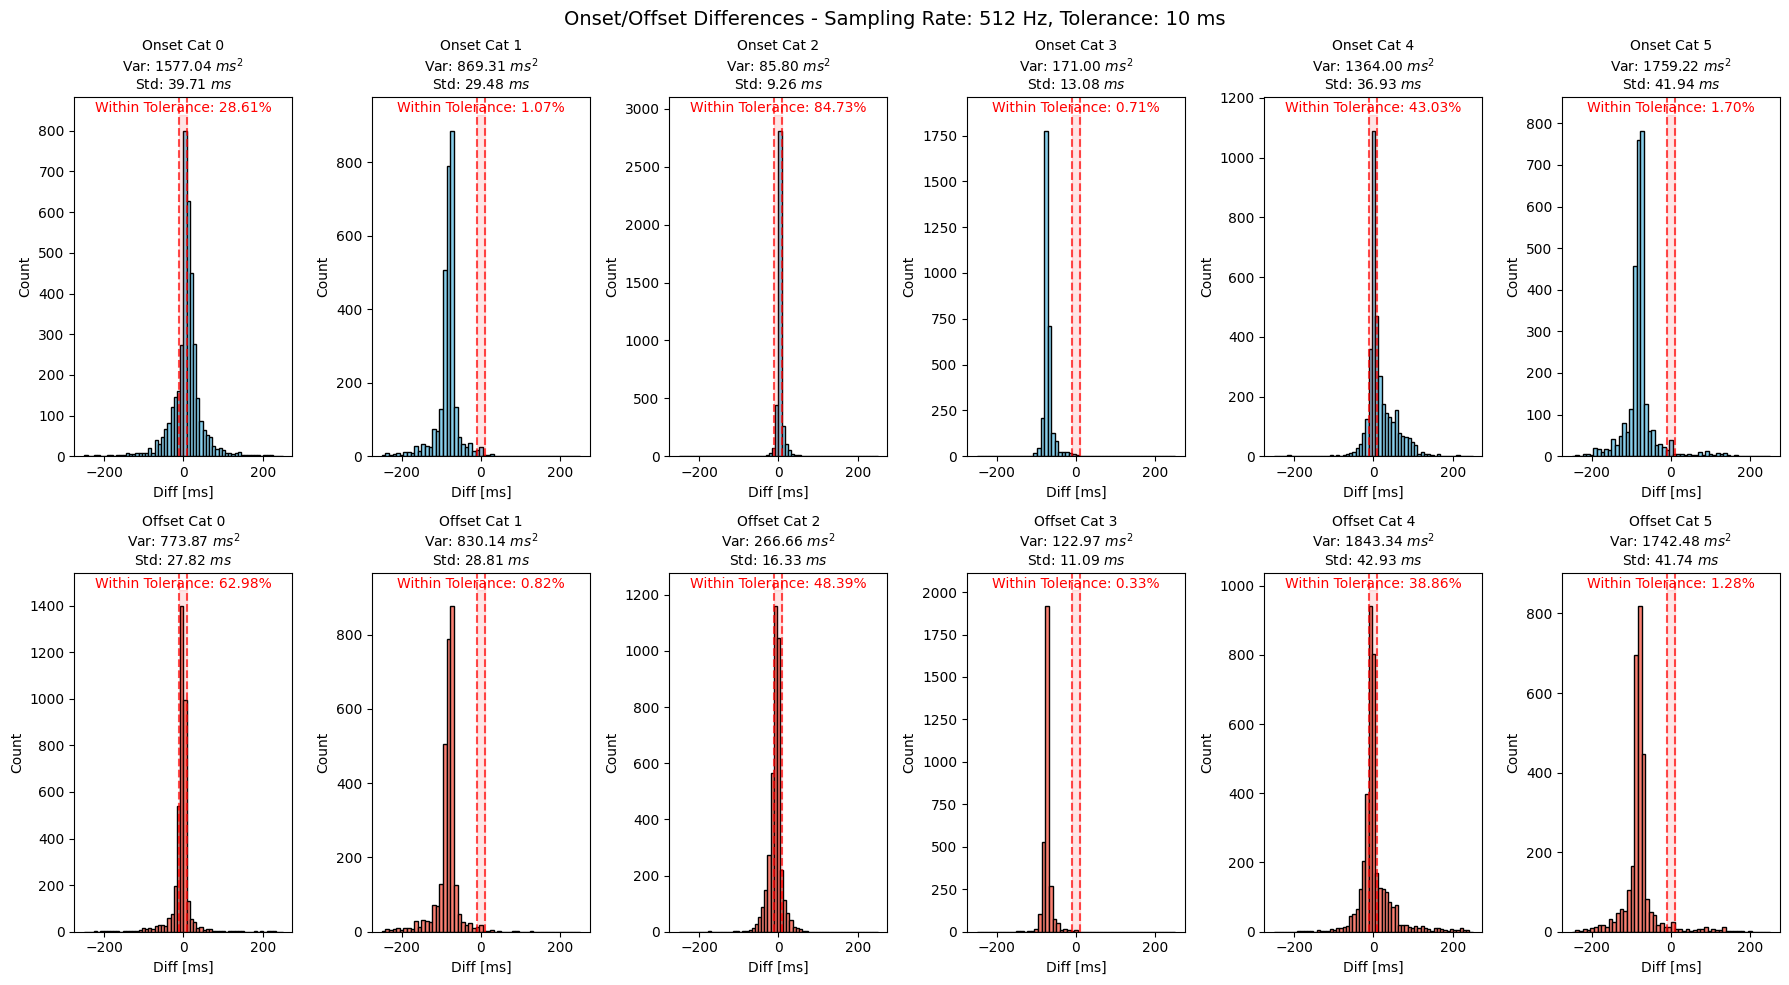

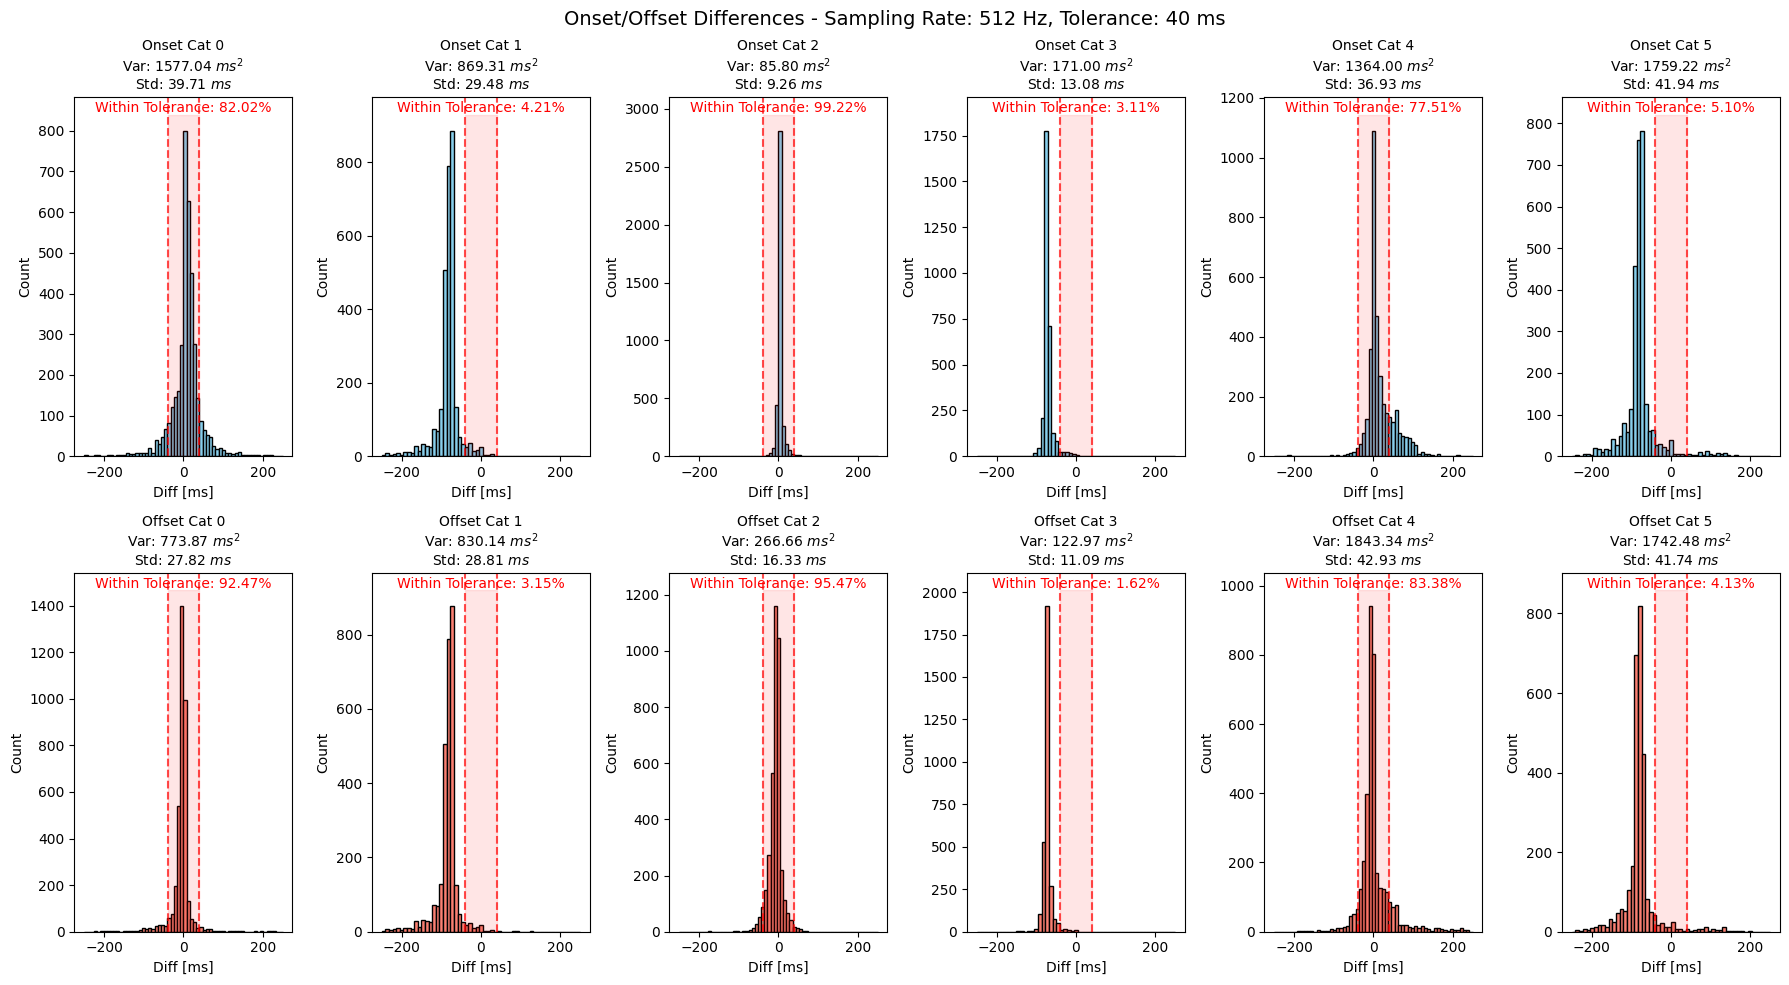

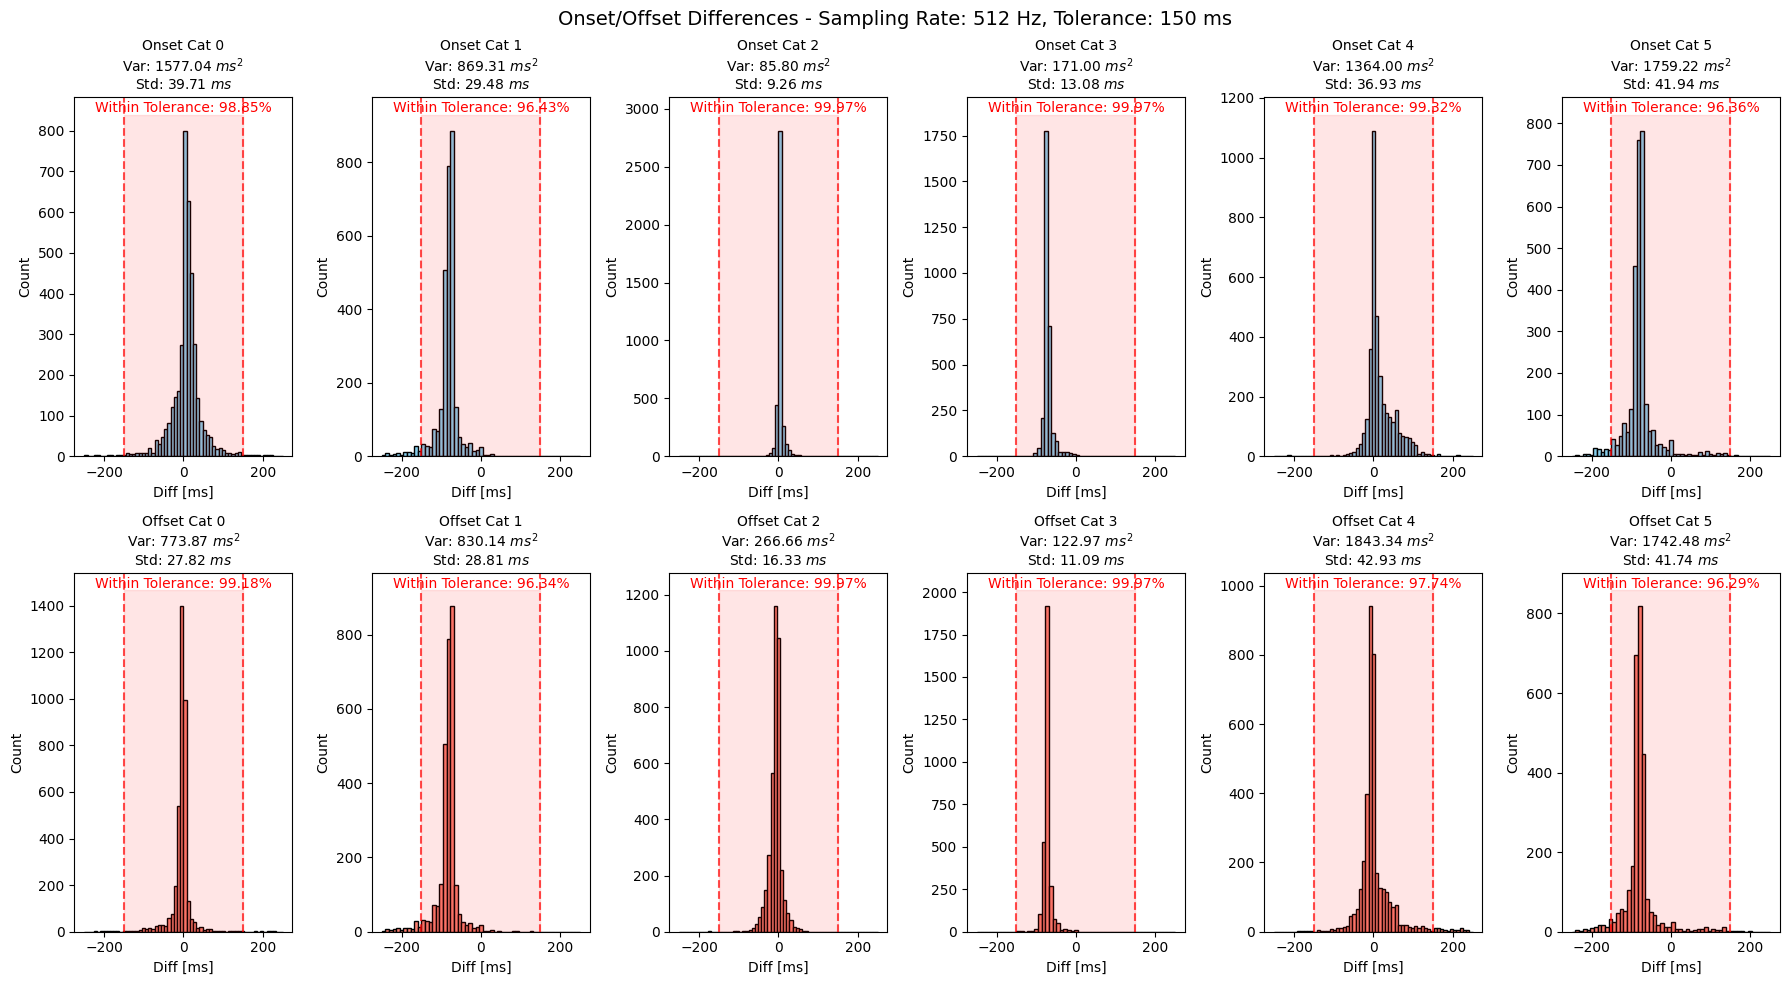

Test Epoch End
-----------------------------------
Testing DataLoader 0: 100%|██████████| 51/51 [02:42<00:00,  0.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               Test metric                             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              test_jaccard                          0.8556150794029236
             test_loss_epoch                        0.4663686752319336
     tolerance_10ms_f1_offset_global                0.5933713912963867
     tolerance_10ms_f1_onset_global                 0.5654110908508301
     tolerance_10ms_fn_offset_global                      10583.0
     tolerance_10ms_fn_onset_global                       10014.0
     tolerance_10ms_fp_offset_global                      1600.0
     tolerance_10ms_fp_onset_global                       2862.0
    tolerance_10ms_ppv_

Best trial: 0. Best value: 0.122472:  40%|████      | 2/5 [08:03<12:13, 244.38s/it]c:\Users\lukas\anaconda3\envs\HKA_EKG_Signalverarbeitung\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Selected leads for this trial: ['I', 'II', 'III', 'AVR', 'AVF', 'V1', 'V2', 'V4', 'V5']
['I', 'II', 'III', 'AVR', 'AVF', 'V1', 'V2', 'V4', 'V5']
I-II-III-AVR-AVF-V1-V2-V4-V5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type                  | Params | Mode  | In sizes      | Out sizes    
-----------------------------------------------------------------------------------------------------------
0  | criterion               | BCEWithLogitsLoss     | 0      | train | ?             | ?            
1  | train_jaccard           | BinaryJaccardIndex    | 0      | train | ?             | ?            
2  | val_jaccard             | BinaryJaccardIndex    | 0      | train | ?             | ?            
3  | test_jaccard            | BinaryJaccardIndex    | 0      | train | ?             | ?            
4  | multi_tolerance_metrics | MultiToleranceWrapper | 0      | train | ?             | ?            
5  | AvgPool1D1              | AvgPool1d             | 0      | train | [1, 64, 512]  | [1, 64, 256] 
6  | AvgPool1D2              | AvgPool1d             | 0      | train | [1, 128, 256] | [1, 128, 128]
7  | AvgPool1D3              | Av

Epoch 2: 100%|██████████| 477/477 [00:19<00:00, 24.77it/s, v_num=67in, train_loss_step=0.245, val_loss_step=0.240, val_loss_epoch=0.245, train_loss_epoch=0.274]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 477/477 [00:20<00:00, 23.82it/s, v_num=67in, train_loss_step=0.245, val_loss_step=0.240, val_loss_epoch=0.245, train_loss_epoch=0.274]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train_loss_epoch,█▄▁
train_loss_step,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
trainer/global_step,▃▁▁▁▂▂▂▄▅▅▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▇▇███▃▄▄▄▄▄▄▄▄▅
val_loss_epoch,█▄▁
val_loss_step,▇▇▇▇█▇█▇▇▇▇▇▇▄▅▄▄▄▄▄▄▄▄▄▄▁▂▁▂▁▁▂▂▁▂▁▁▂▂▂
epoch,2
train_loss_epoch,0.27384
train_loss_step,0.24372
trainer/global_step,716
val_loss_epoch,0.24458


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model checkpoint saved as C:\Users\lukas\Documents\HKA_DEV\HKA_EKG_Signalverarbeitung_Data\models\type_bs32_lr1.4e-03_wd5.0e-03_optAdamW_schReduceLROnPlateau_acc2_leadsI-II-III-AVR-AVF-V1-V2-V4-V5_2025-09-17_09-04\model_best_ckpt.ckpt
Optimization finished with best validation loss: 0.24458007514476776
type_bs32_lr1.4e-03_wd5.0e-03_optAdamW_schReduceLROnPlateau_acc2_leadsI-II-III-AVR-AVF-V1-V2-V4-V5_2025-09-17_09-04
Testing DataLoader 0: 100%|██████████| 101/101 [01:49<00:00,  0.92it/s]

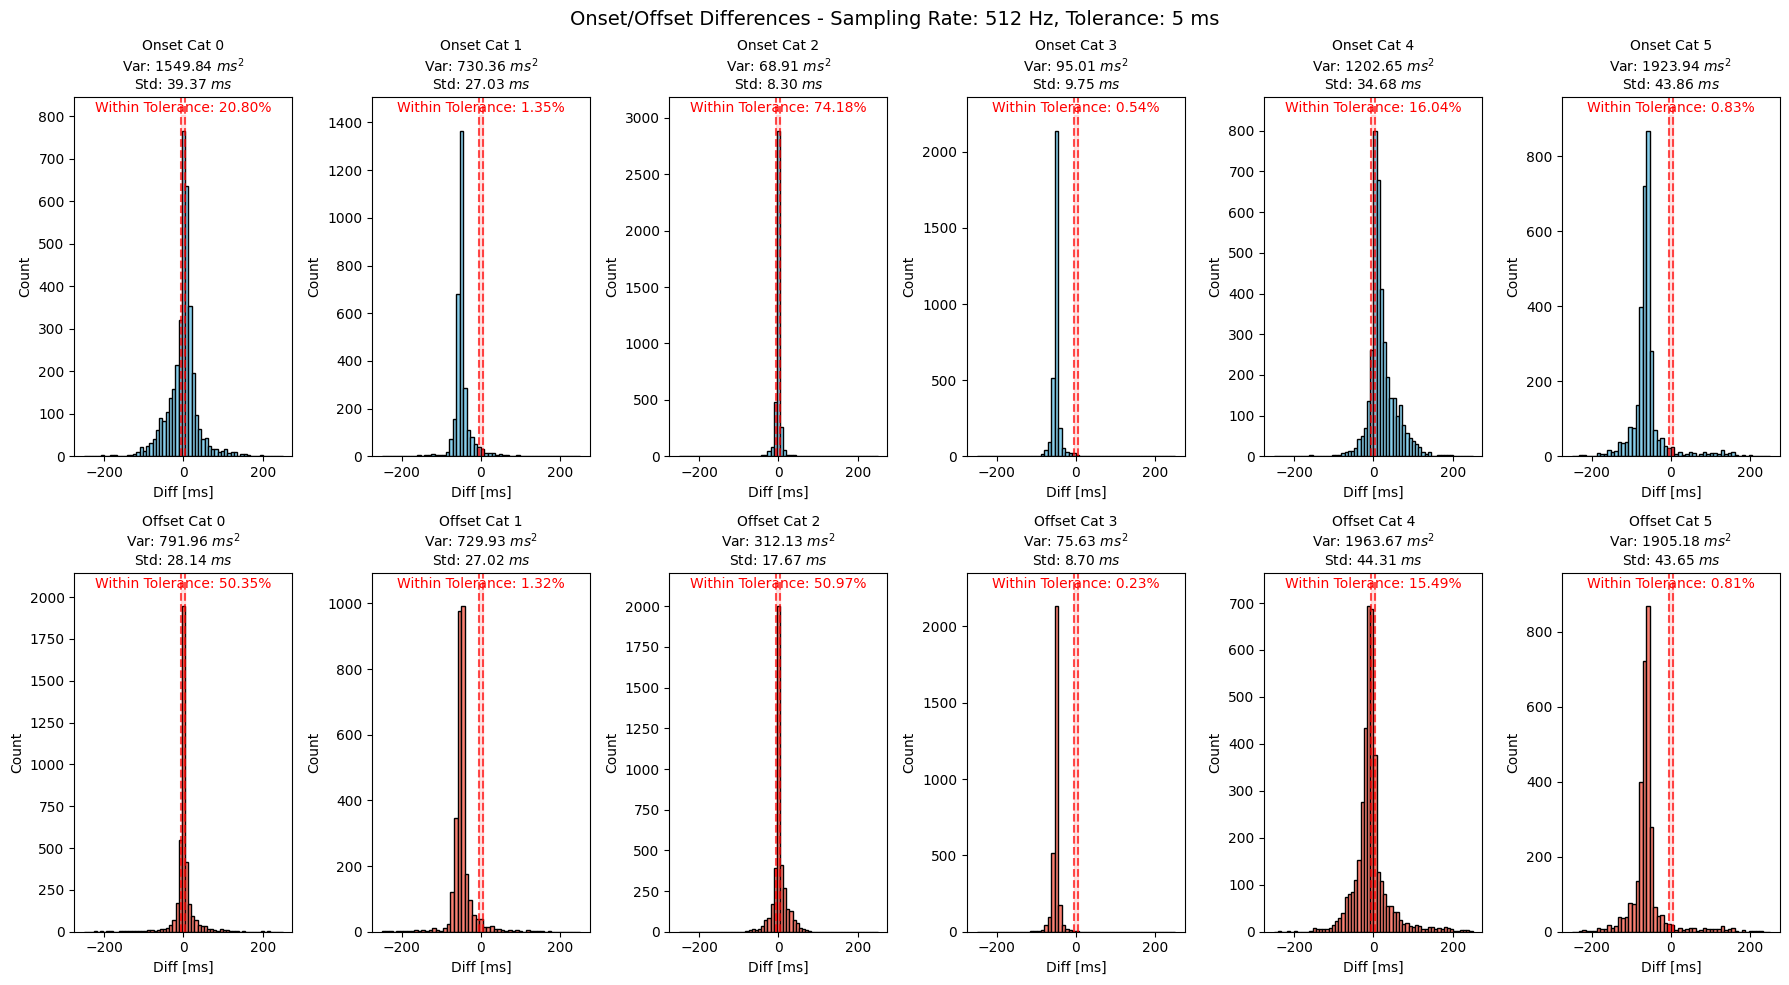

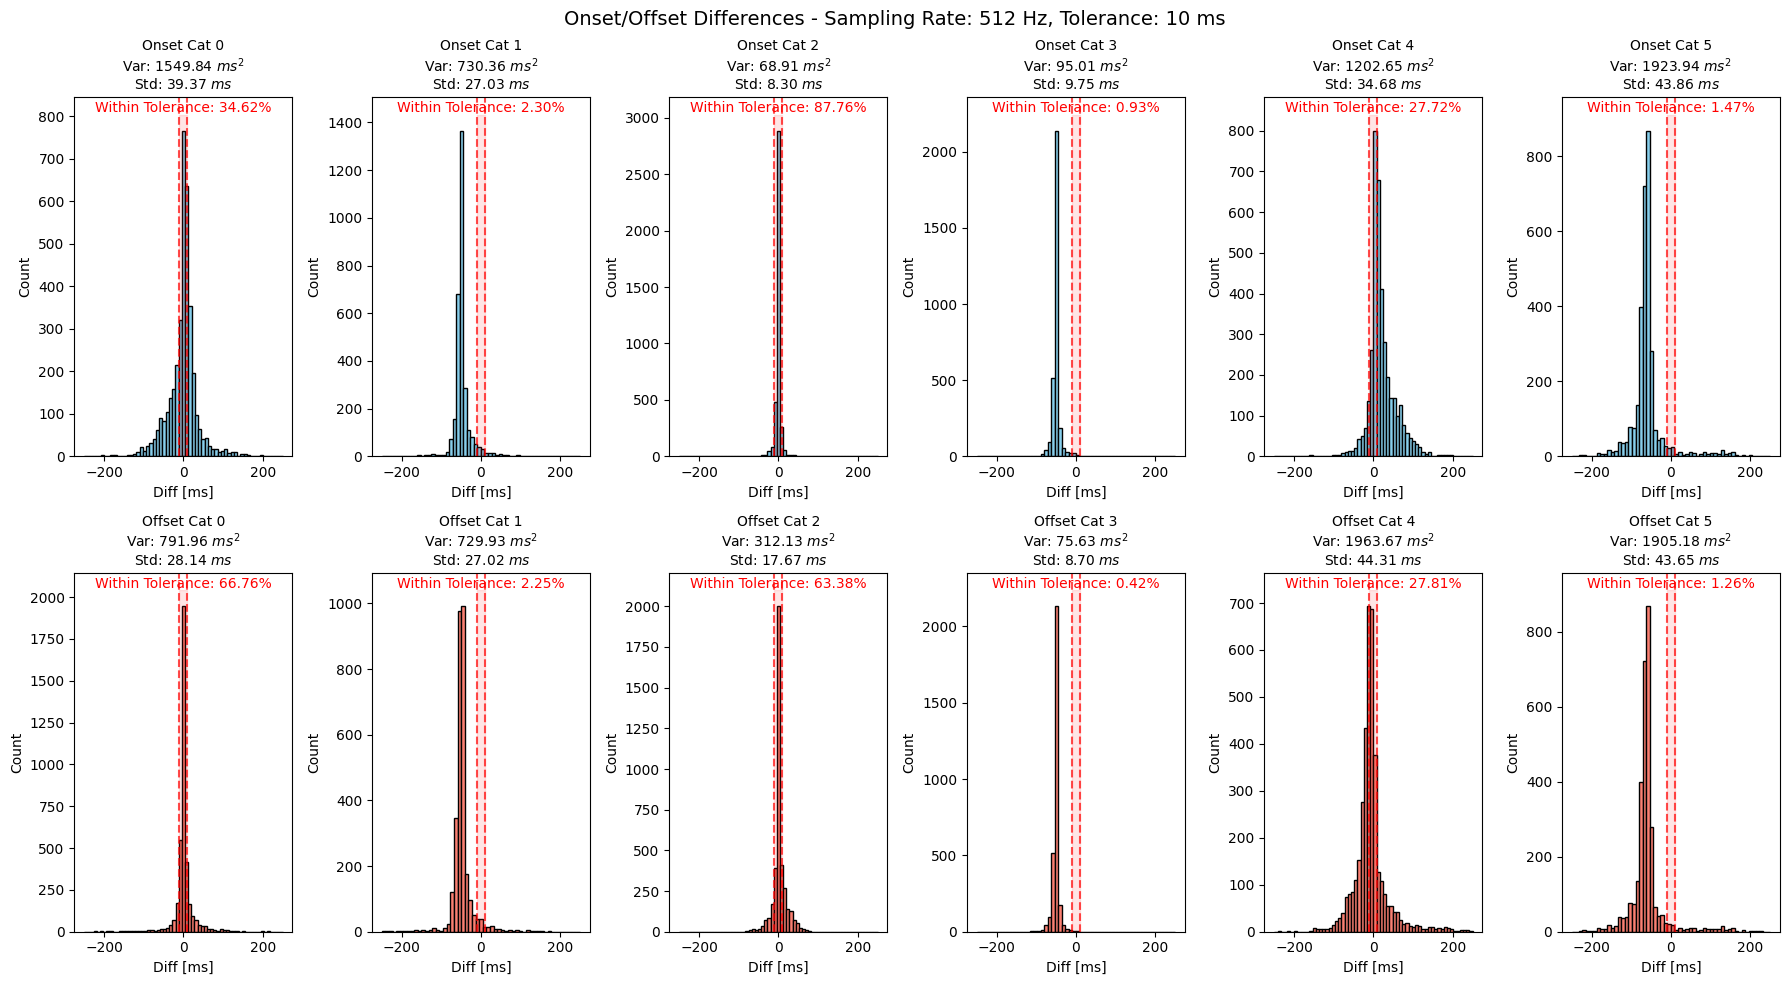

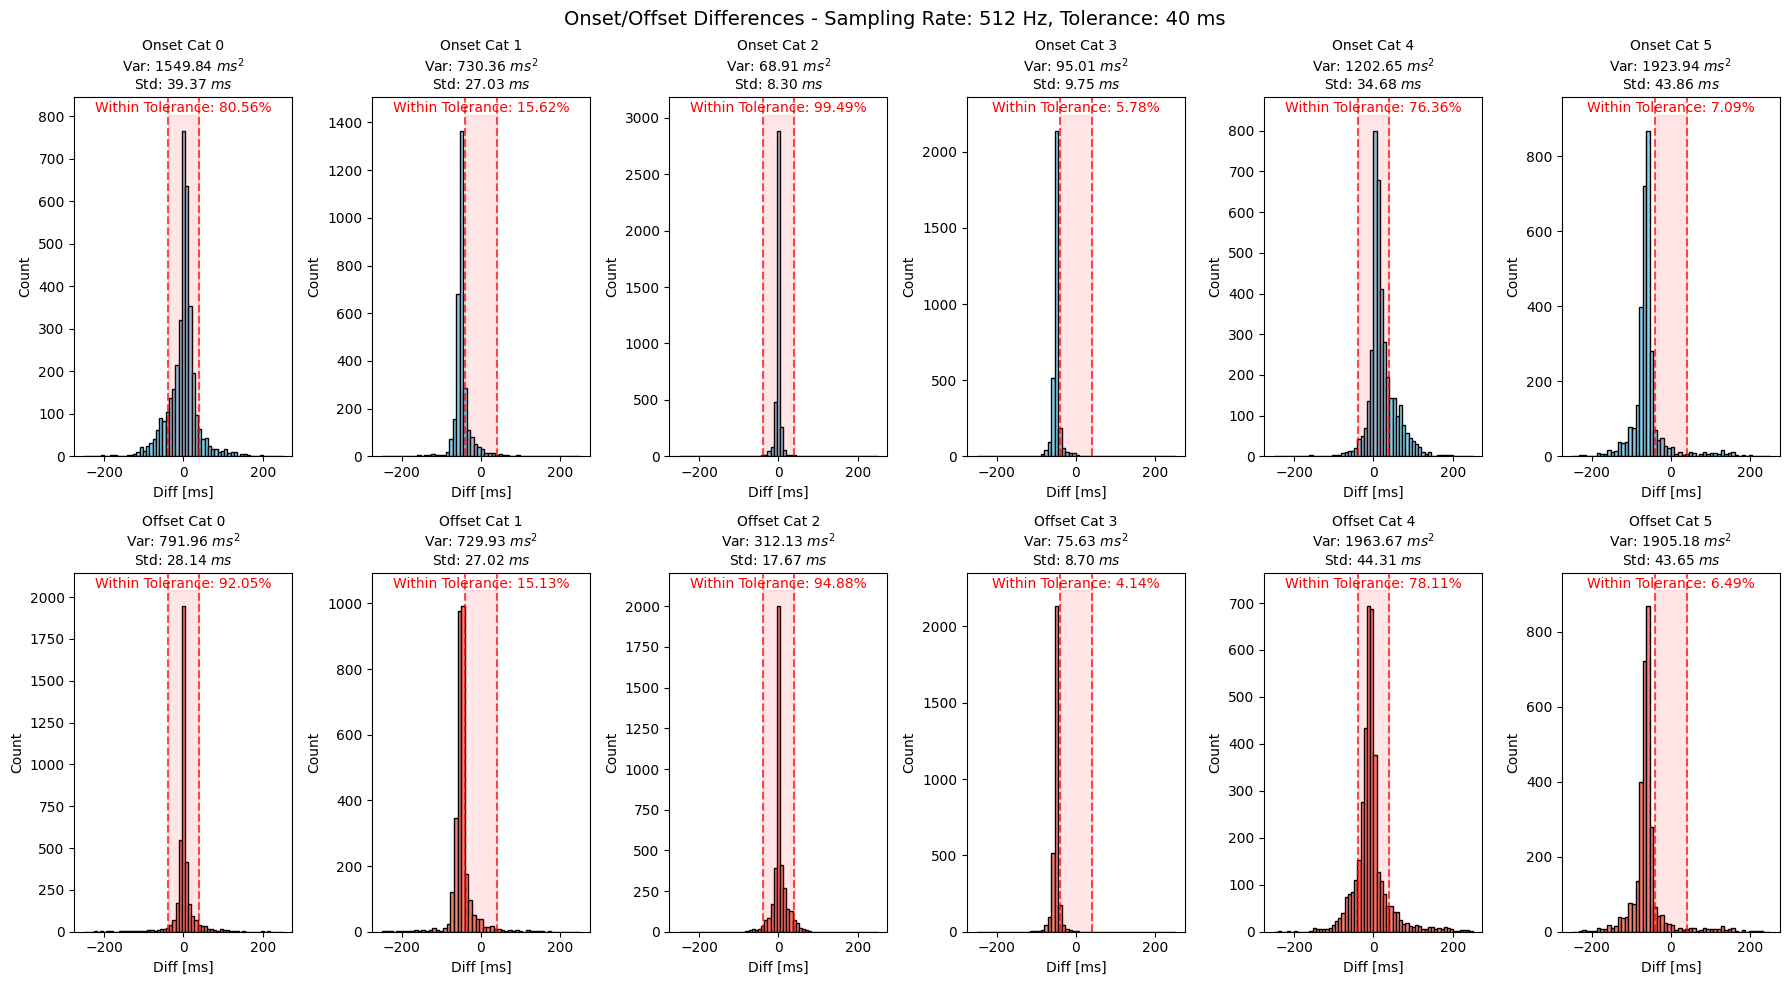

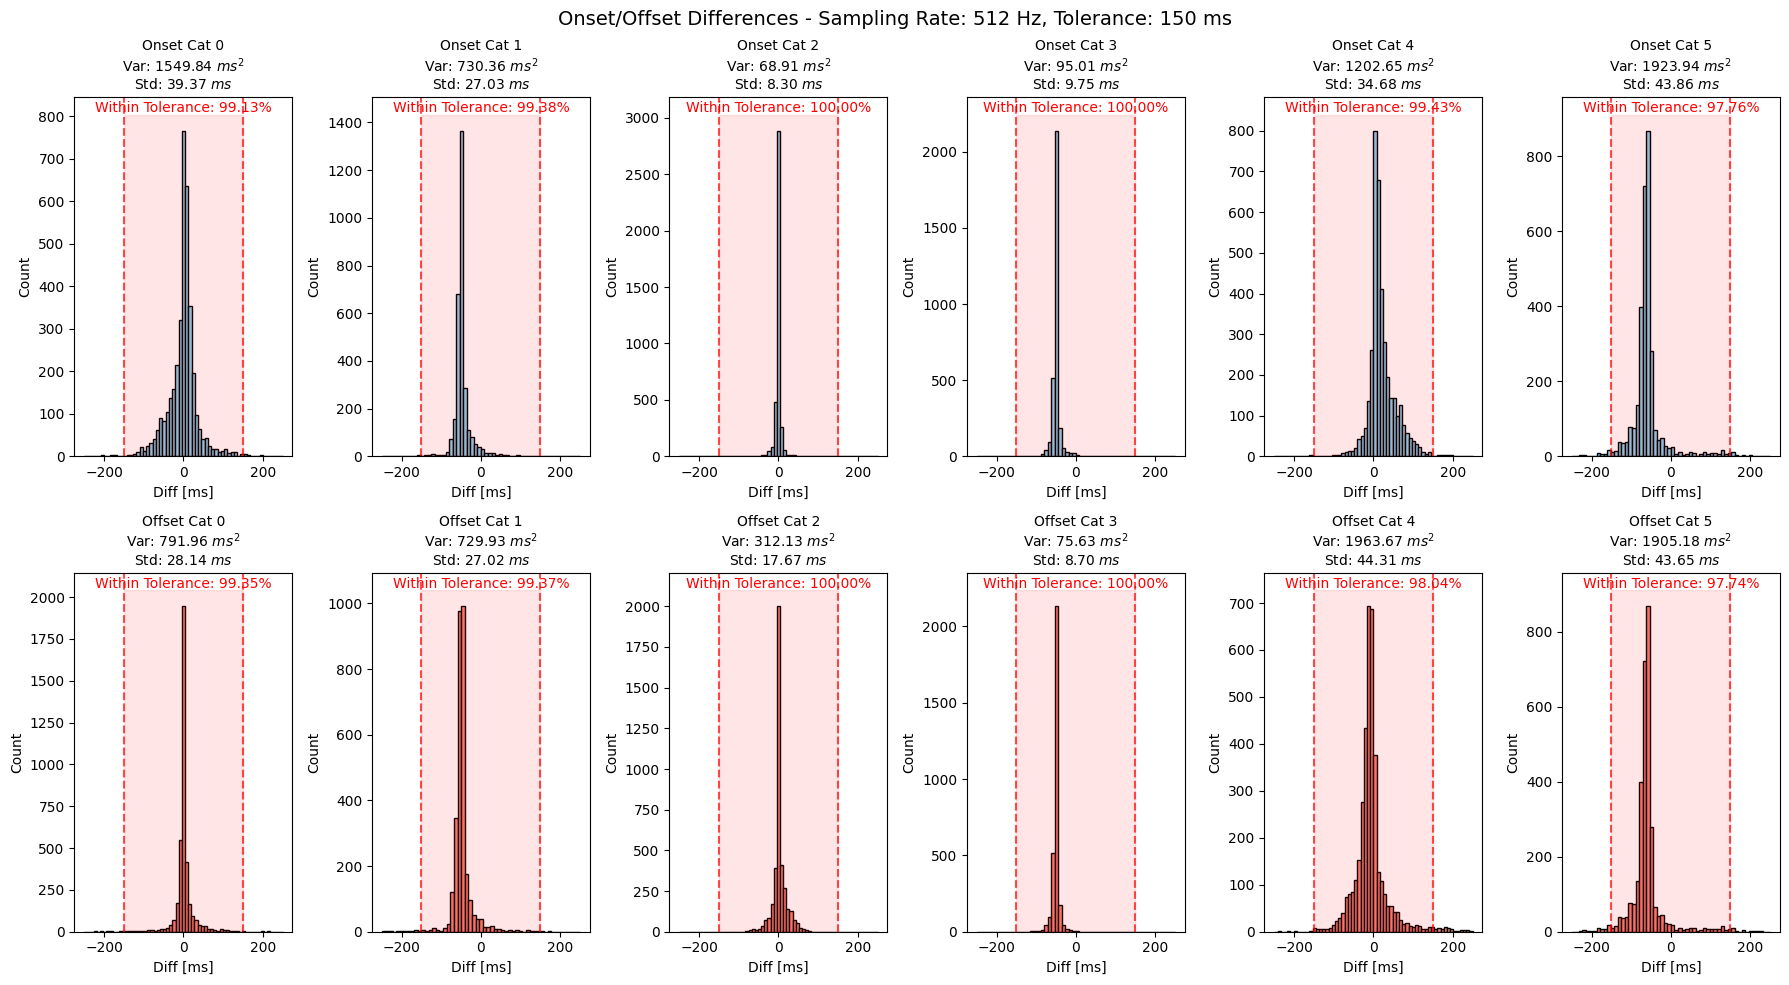

Test Epoch End
-----------------------------------
Testing DataLoader 0: 100%|██████████| 101/101 [01:55<00:00,  0.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               Test metric                             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              test_jaccard                          0.8523055911064148
             test_loss_epoch                        0.24428991973400116
     tolerance_10ms_f1_offset_global                0.5945945382118225
     tolerance_10ms_f1_onset_global                 0.5745621919631958
     tolerance_10ms_fn_offset_global                      10436.0
     tolerance_10ms_fn_onset_global                       9974.0
     tolerance_10ms_fp_offset_global                      1744.0
     tolerance_10ms_fp_onset_global                       2633.0
    tolerance_10ms_pp

Best trial: 0. Best value: 0.122472:  60%|██████    | 3/5 [11:40<07:43, 231.74s/it]c:\Users\lukas\anaconda3\envs\HKA_EKG_Signalverarbeitung\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Selected leads for this trial: ['AVF', 'V1', 'V2', 'V3']
['AVF', 'V1', 'V2', 'V3']
AVF-V1-V2-V3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type                  | Params | Mode  | In sizes      | Out sizes    
-----------------------------------------------------------------------------------------------------------
0  | criterion               | BCEWithLogitsLoss     | 0      | train | ?             | ?            
1  | train_jaccard           | BinaryJaccardIndex    | 0      | train | ?             | ?            
2  | val_jaccard             | BinaryJaccardIndex    | 0      | train | ?             | ?            
3  | test_jaccard            | BinaryJaccardIndex    | 0      | train | ?             | ?            
4  | multi_tolerance_metrics | MultiToleranceWrapper | 0      | train | ?             | ?            
5  | AvgPool1D1              | AvgPool1d             | 0      | train | [1, 64, 512]  | [1, 64, 256] 
6  | AvgPool1D2              | AvgPool1d             | 0      | train | [1, 128, 256] | [1, 128, 128]
7  | AvgPool1D3              | Av

Epoch 2: 100%|██████████| 477/477 [00:21<00:00, 22.63it/s, v_num=efy1, train_loss_step=0.366, val_loss_step=0.370, val_loss_epoch=0.376, train_loss_epoch=0.387]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 477/477 [00:22<00:00, 21.52it/s, v_num=efy1, train_loss_step=0.366, val_loss_step=0.370, val_loss_epoch=0.376, train_loss_epoch=0.387]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅█████████████████
train_loss_epoch,█▄▁
train_loss_step,█▇▆▆▇▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▂▁▁
trainer/global_step,▁▁▂▃▃▁▁▁▁▁▁▁▁▁▁▅▅▅▆▆▂▂▂▂▂▂▂▆▆██▂▂▂▂▂▂▂▂▃
val_loss_epoch,█▄▁
val_loss_step,▇▇██▇▇█▇▇▇▇█▇█▇▄▄▄▄▄▃▄▄▄▄▅▁▁▂▃▂▁▁▂▁▁▂▂▂▁
epoch,2
train_loss_epoch,0.38727
train_loss_step,0.35707
trainer/global_step,1430
val_loss_epoch,0.37639


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model checkpoint saved as C:\Users\lukas\Documents\HKA_DEV\HKA_EKG_Signalverarbeitung_Data\models\type_bs32_lr2.9e-04_wd2.8e-04_optAdam_schReduceLROnPlateau_acc1_leadsAVF-V1-V2-V3_2025-09-17_09-08\model_best_ckpt.ckpt
Optimization finished with best validation loss: 0.3763895630836487
type_bs32_lr2.9e-04_wd2.8e-04_optAdam_schReduceLROnPlateau_acc1_leadsAVF-V1-V2-V3_2025-09-17_09-08
Testing DataLoader 0: 100%|██████████| 101/101 [02:26<00:00,  0.69it/s]

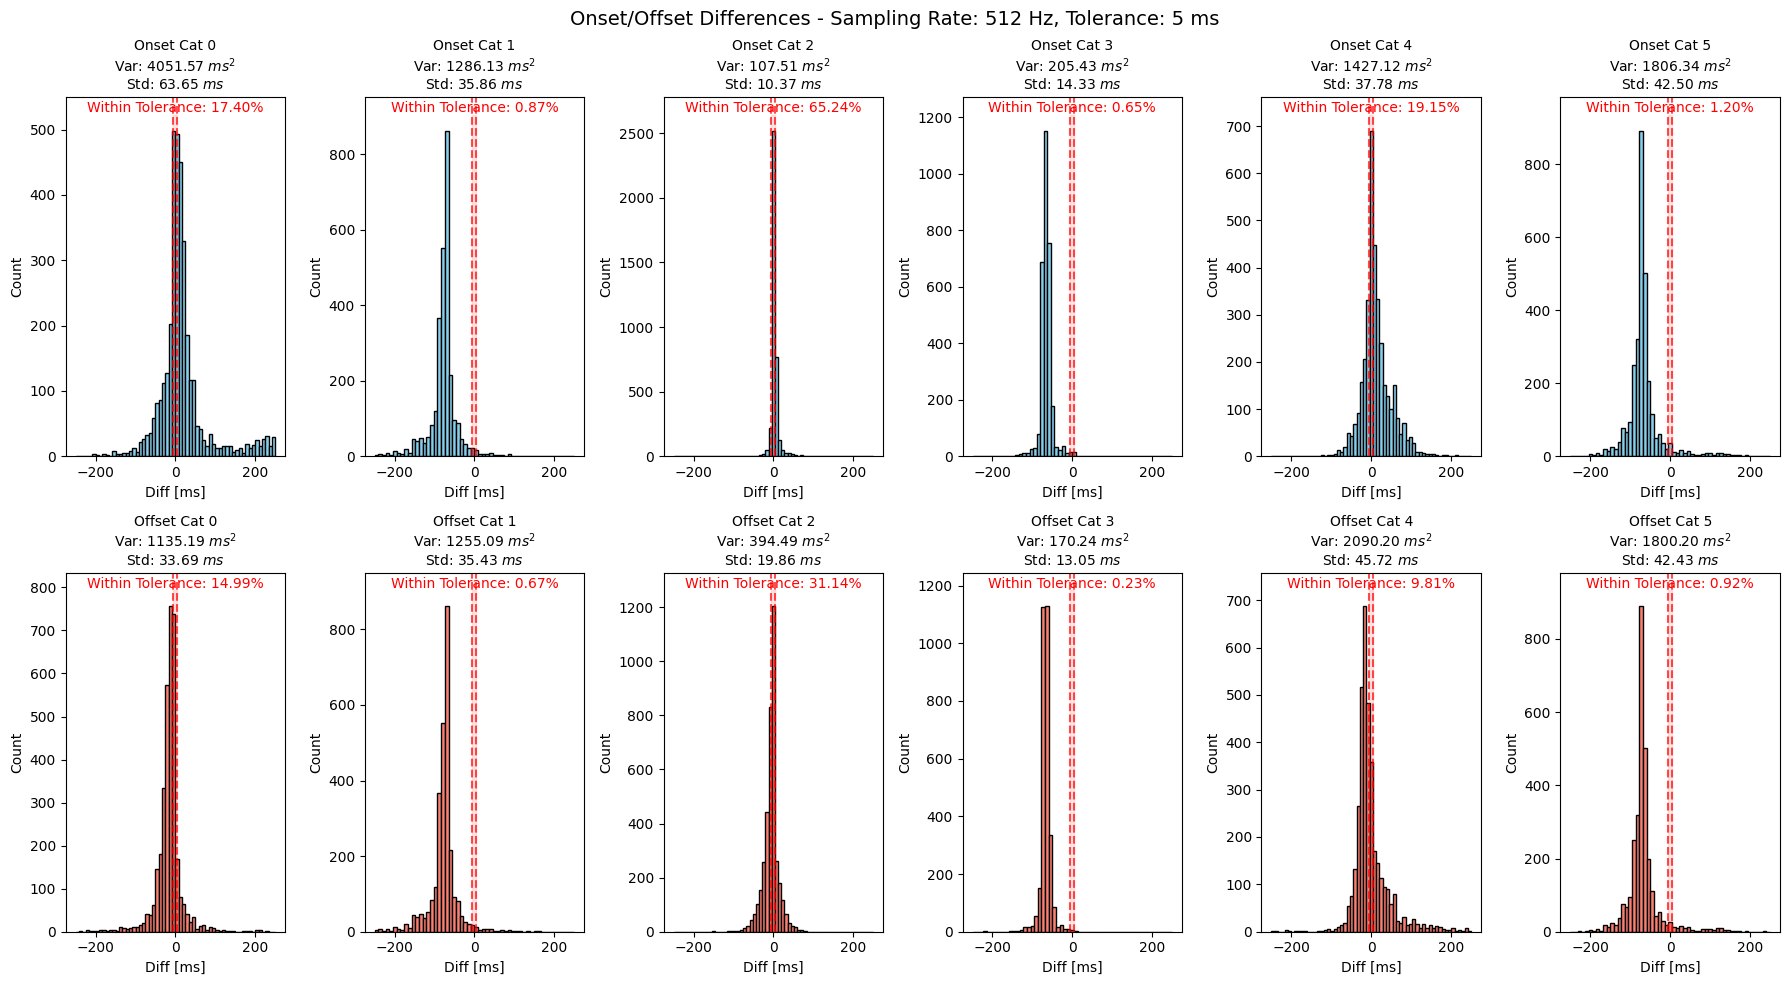

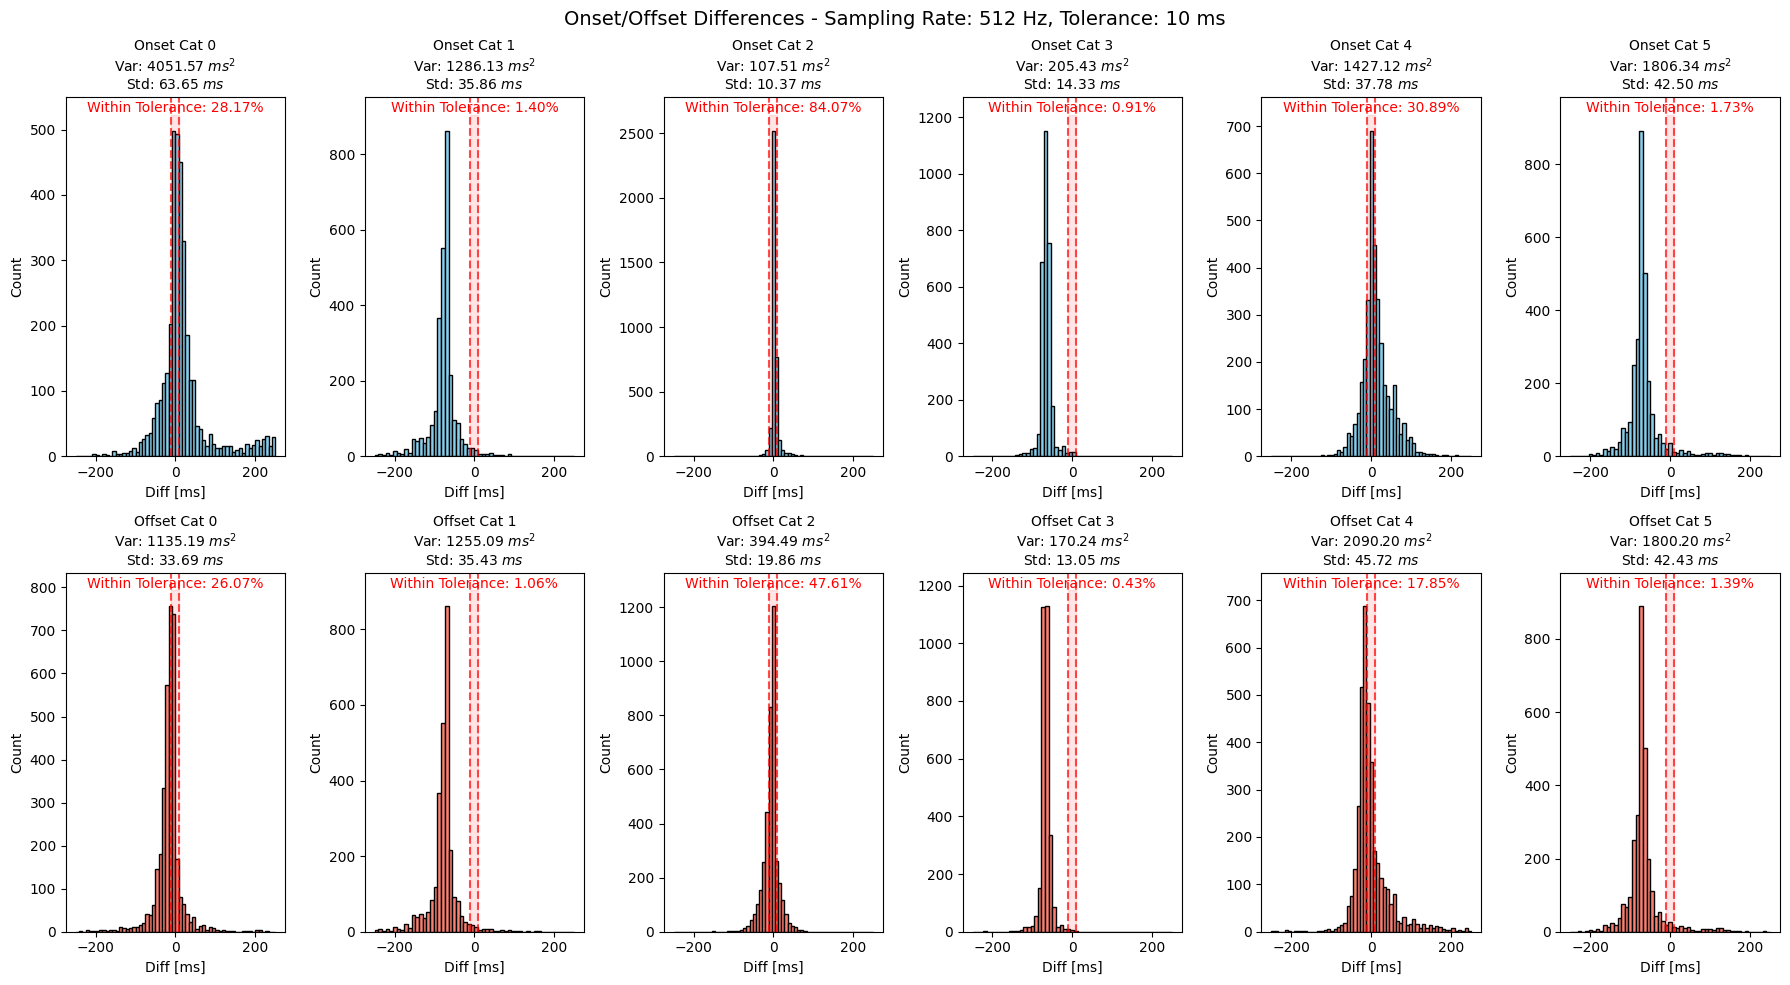

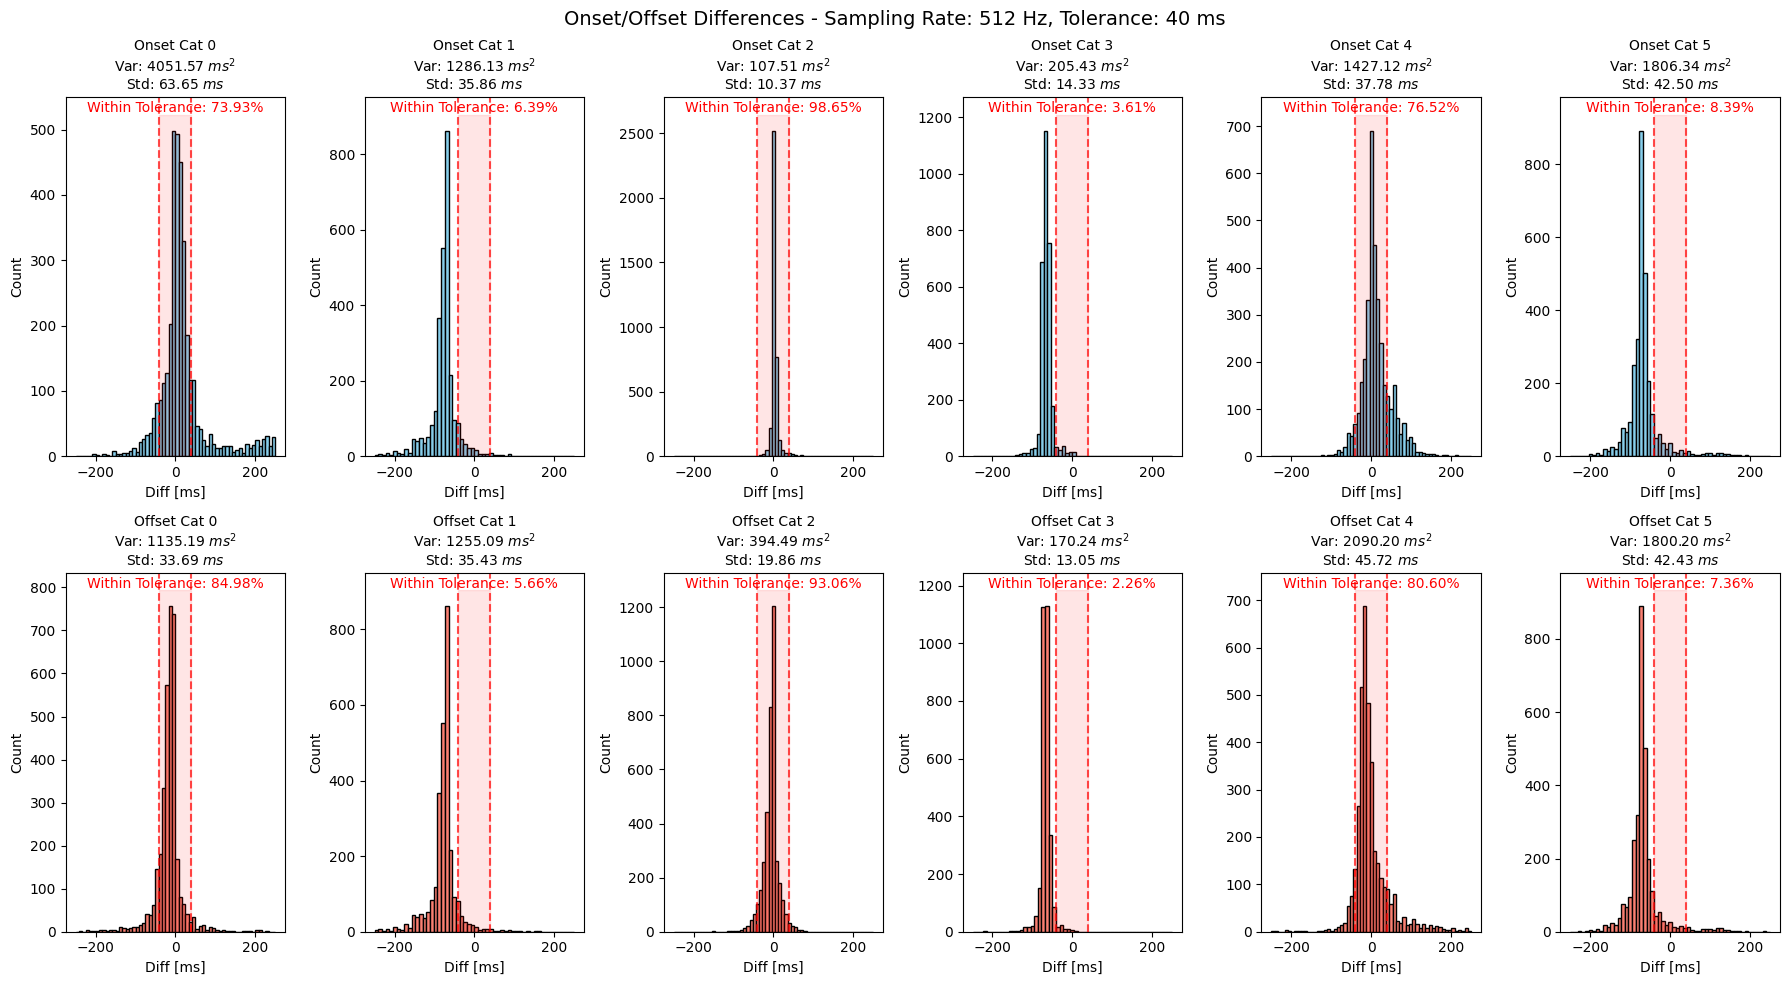

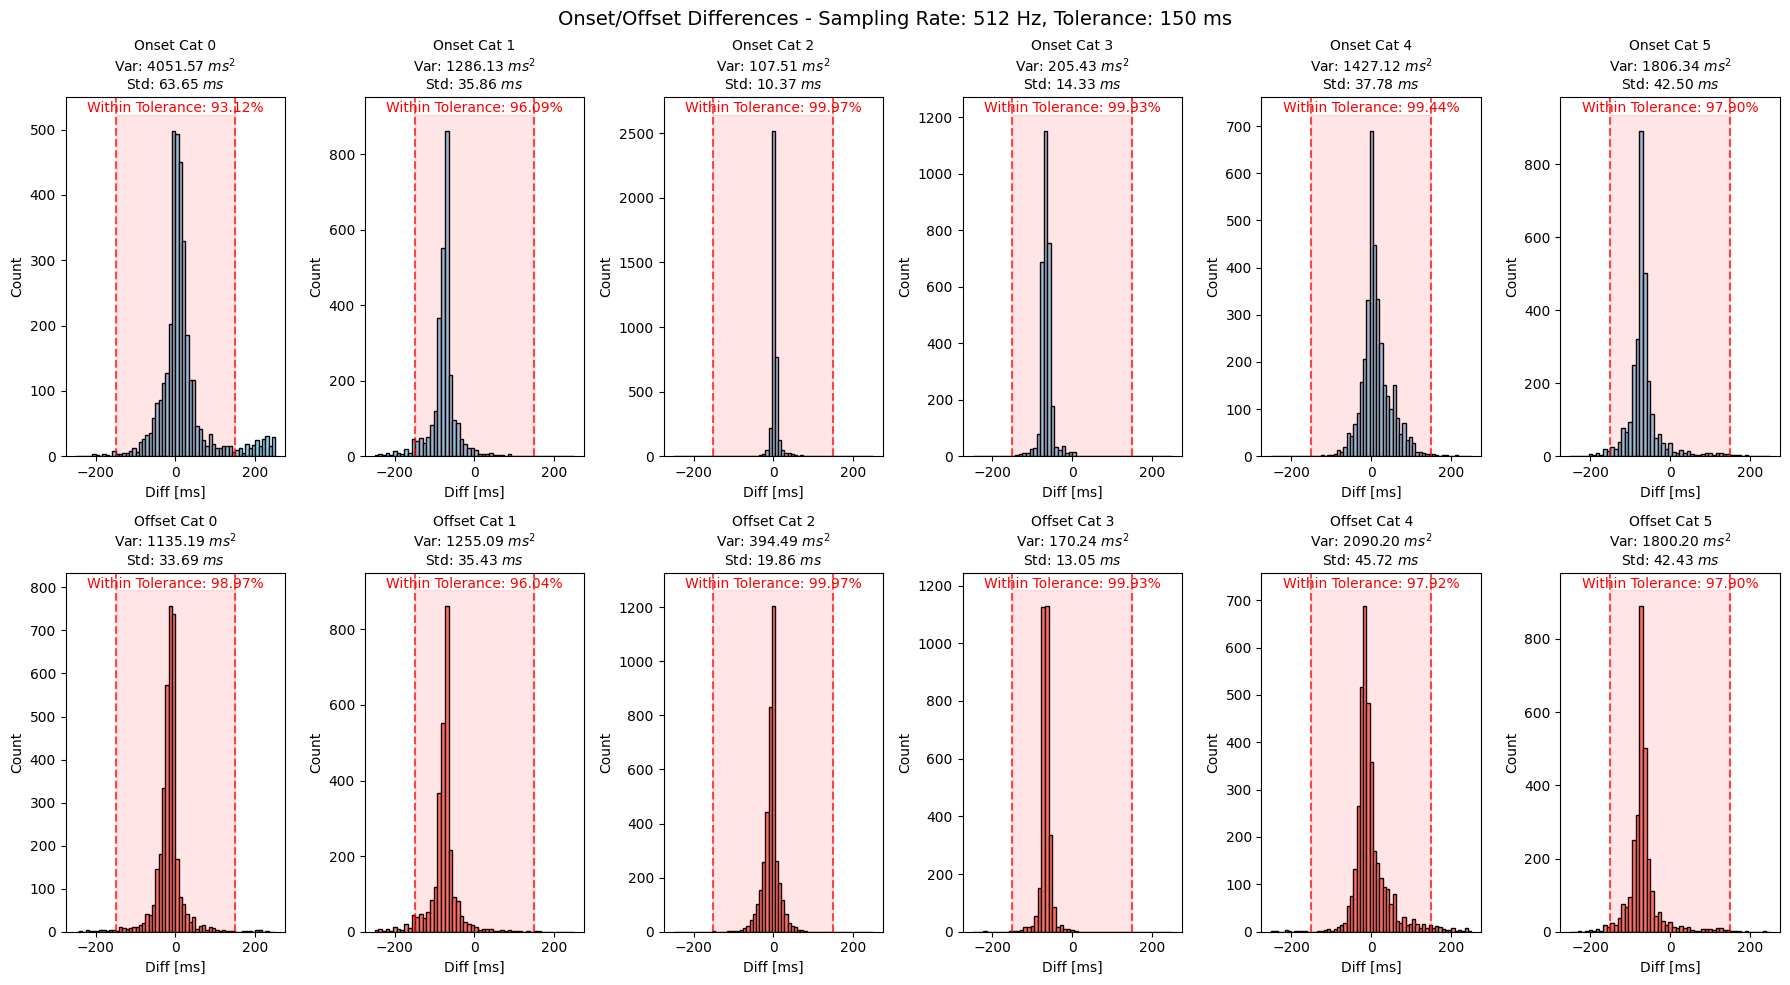

Test Epoch End
-----------------------------------
Testing DataLoader 0: 100%|██████████| 101/101 [02:32<00:00,  0.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               Test metric                             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              test_jaccard                          0.8132649660110474
             test_loss_epoch                        0.37534964084625244
     tolerance_10ms_f1_offset_global                0.5013307332992554
     tolerance_10ms_f1_onset_global                 0.5369468331336975
     tolerance_10ms_fn_offset_global                      11928.0
     tolerance_10ms_fn_onset_global                       10176.0
     tolerance_10ms_fp_offset_global                      2125.0
     tolerance_10ms_fp_onset_global                       3322.0
    tolerance_10ms_p

Best trial: 0. Best value: 0.122472:  80%|████████  | 4/5 [15:56<04:01, 241.63s/it]c:\Users\lukas\anaconda3\envs\HKA_EKG_Signalverarbeitung\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Selected leads for this trial: ['III', 'AVF', 'V1', 'V2', 'V3', 'V6']
['III', 'AVF', 'V1', 'V2', 'V3', 'V6']
III-AVF-V1-V2-V3-V6


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type                  | Params | Mode  | In sizes      | Out sizes    
-----------------------------------------------------------------------------------------------------------
0  | criterion               | BCEWithLogitsLoss     | 0      | train | ?             | ?            
1  | train_jaccard           | BinaryJaccardIndex    | 0      | train | ?             | ?            
2  | val_jaccard             | BinaryJaccardIndex    | 0      | train | ?             | ?            
3  | test_jaccard            | BinaryJaccardIndex    | 0      | train | ?             | ?            
4  | multi_tolerance_metrics | MultiToleranceWrapper | 0      | train | ?             | ?            
5  | AvgPool1D1              | AvgPool1d             | 0      | train | [1, 64, 512]  | [1, 64, 256] 
6  | AvgPool1D2              | AvgPool1d             | 0      | train | [1, 128, 256] | [1, 128, 128]
7  | AvgPool1D3              | Av

Epoch 2: 100%|██████████| 954/954 [00:29<00:00, 32.85it/s, v_num=l44x, train_loss_step=0.555, val_loss_step=0.562, val_loss_epoch=0.552, train_loss_epoch=0.565]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 954/954 [00:29<00:00, 32.31it/s, v_num=l44x, train_loss_step=0.555, val_loss_step=0.562, val_loss_epoch=0.552, train_loss_epoch=0.565]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train_loss_epoch,█▃▁
train_loss_step,█▇▆▄▄▄▄▃▃▃▃▂▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▄▅▆▇▇▇▇▇████
val_loss_epoch,█▄▁
val_loss_step,▃█▃▄▃▅▃▅▄▄▄▆▄▄▃▄▂▃▂▃▃▃▂▃▃▂▃▅▂▃▂▅▁▂▂▂▁▁▁▂
epoch,2
train_loss_epoch,0.56466
train_loss_step,0.55471
trainer/global_step,359
val_loss_epoch,0.55218


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model checkpoint saved as C:\Users\lukas\Documents\HKA_DEV\HKA_EKG_Signalverarbeitung_Data\models\type_bs16_lr4.2e-04_wd1.2e-03_optSGD_schStepLR_acc8_leadsIII-AVF-V1-V2-V3-V6_2025-09-17_09-12\model_best_ckpt.ckpt
Optimization finished with best validation loss: 0.5521832704544067
type_bs16_lr4.2e-04_wd1.2e-03_optSGD_schStepLR_acc8_leadsIII-AVF-V1-V2-V3-V6_2025-09-17_09-12
Testing DataLoader 0: 100%|██████████| 202/202 [03:50<00:00,  0.88it/s]

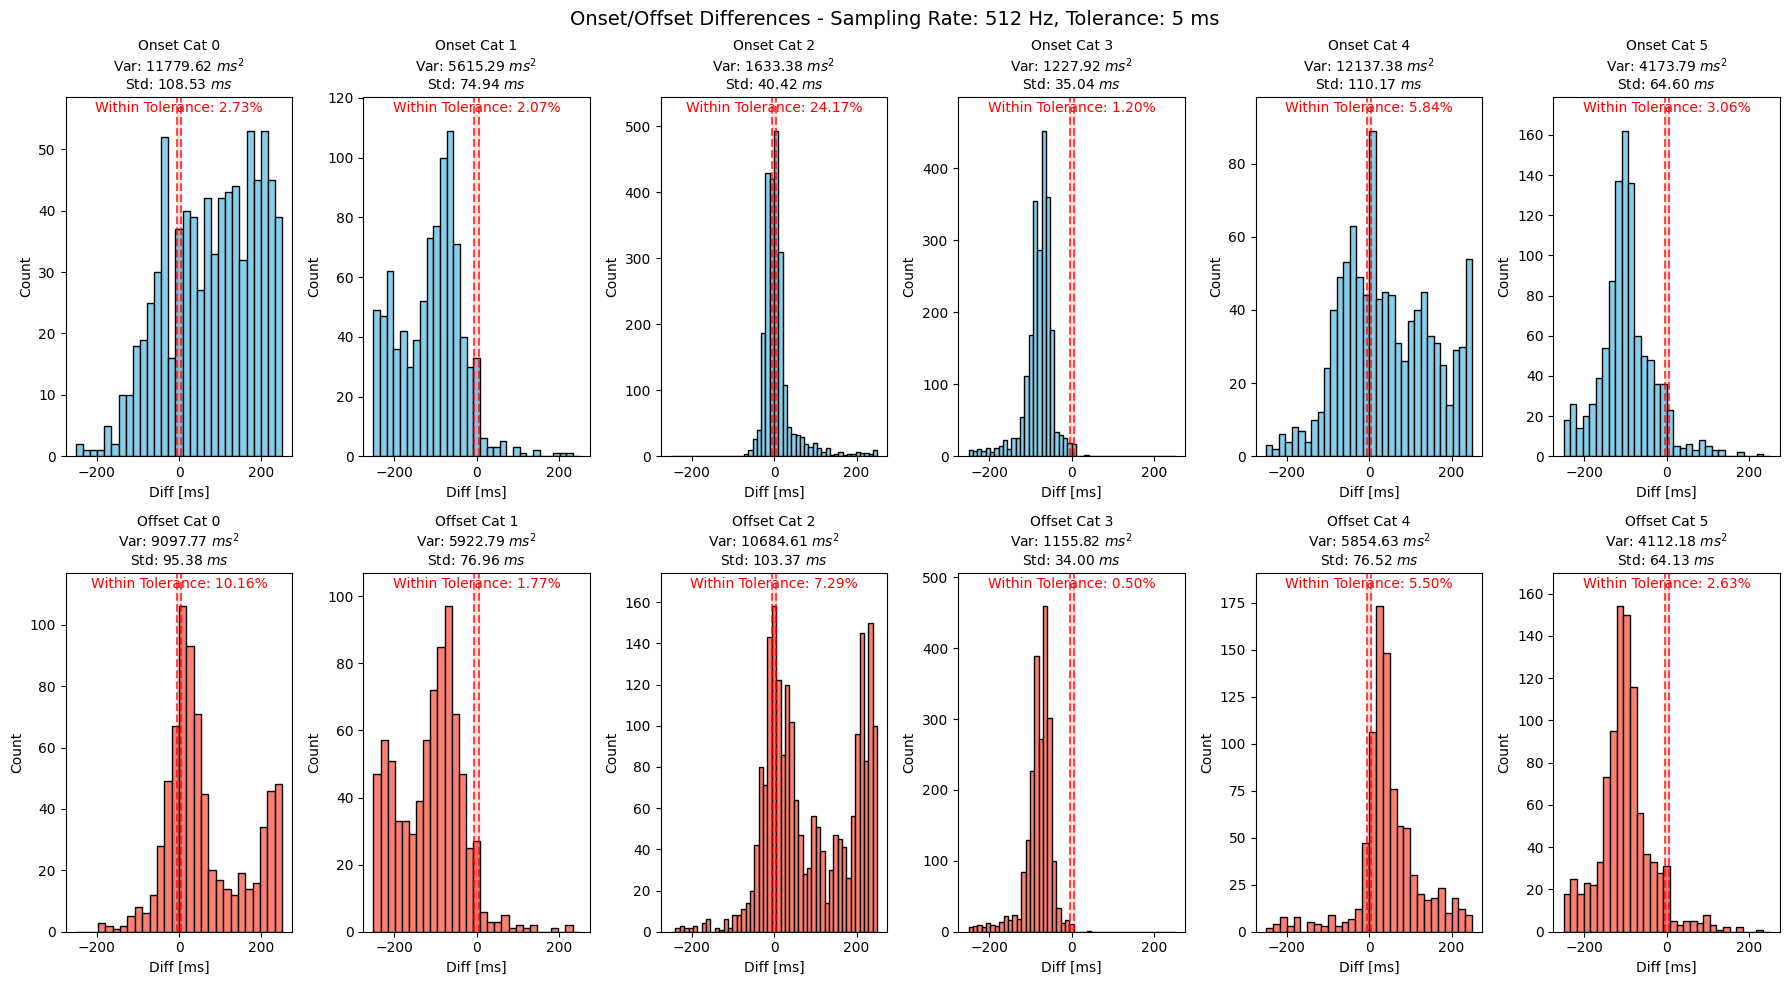

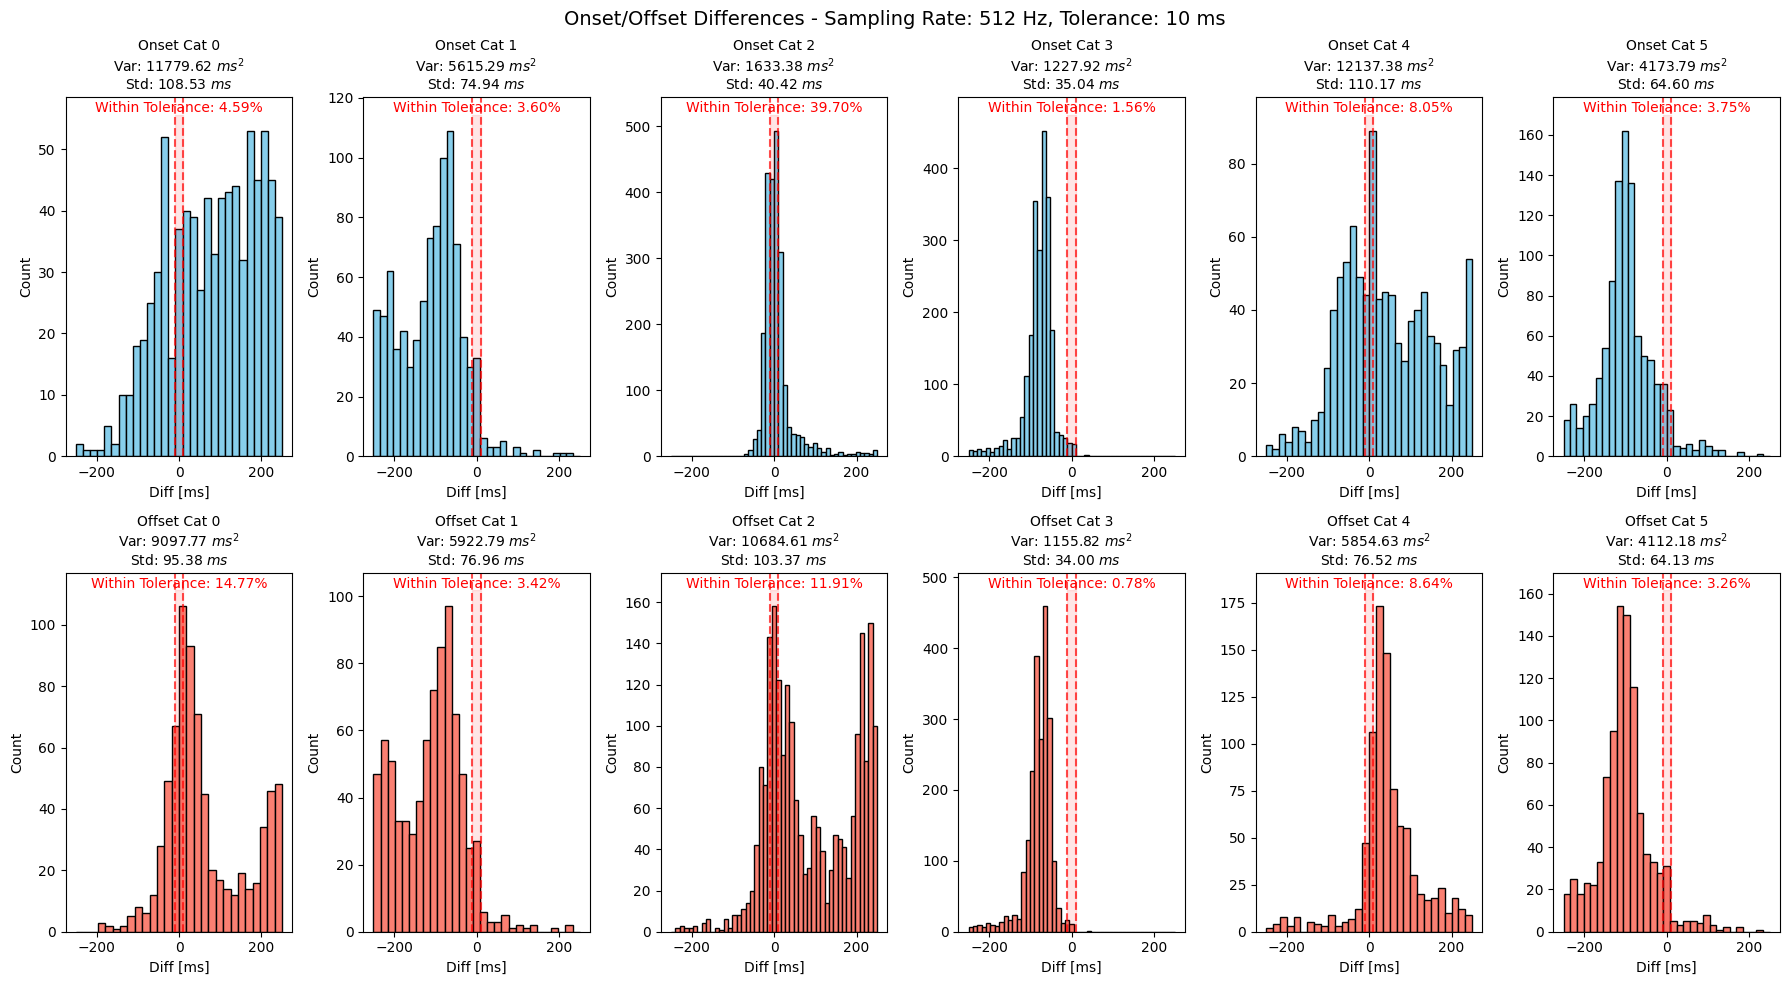

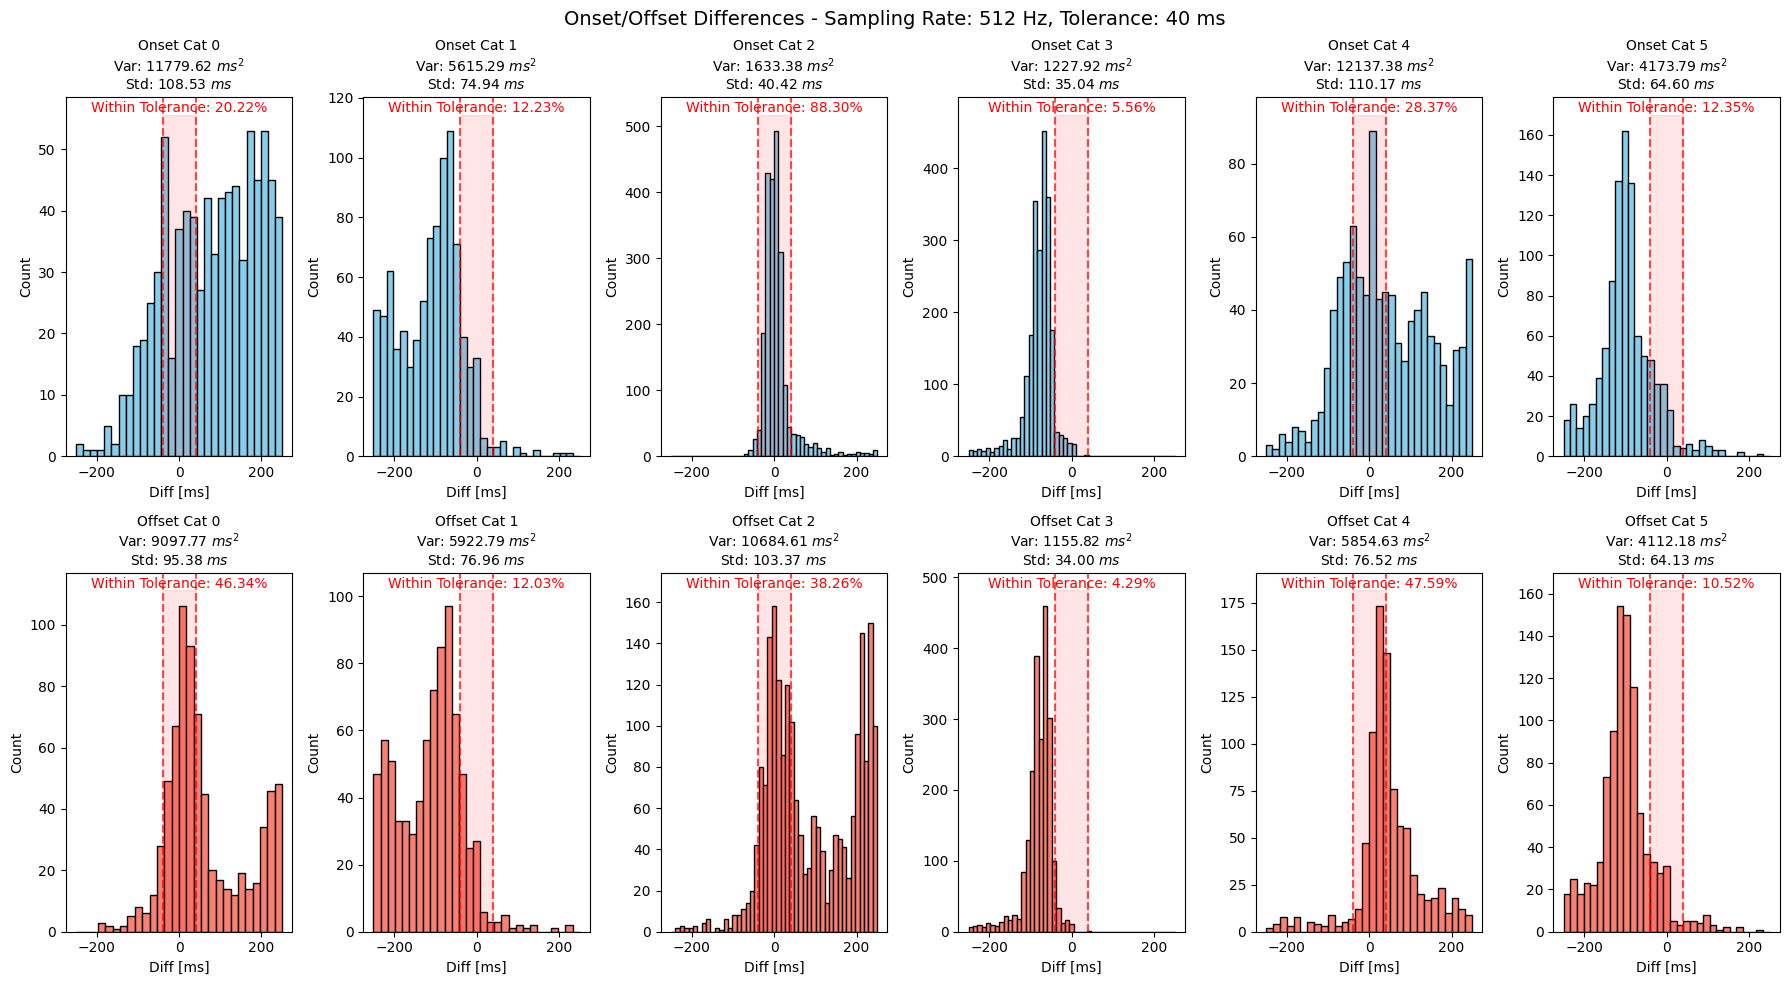

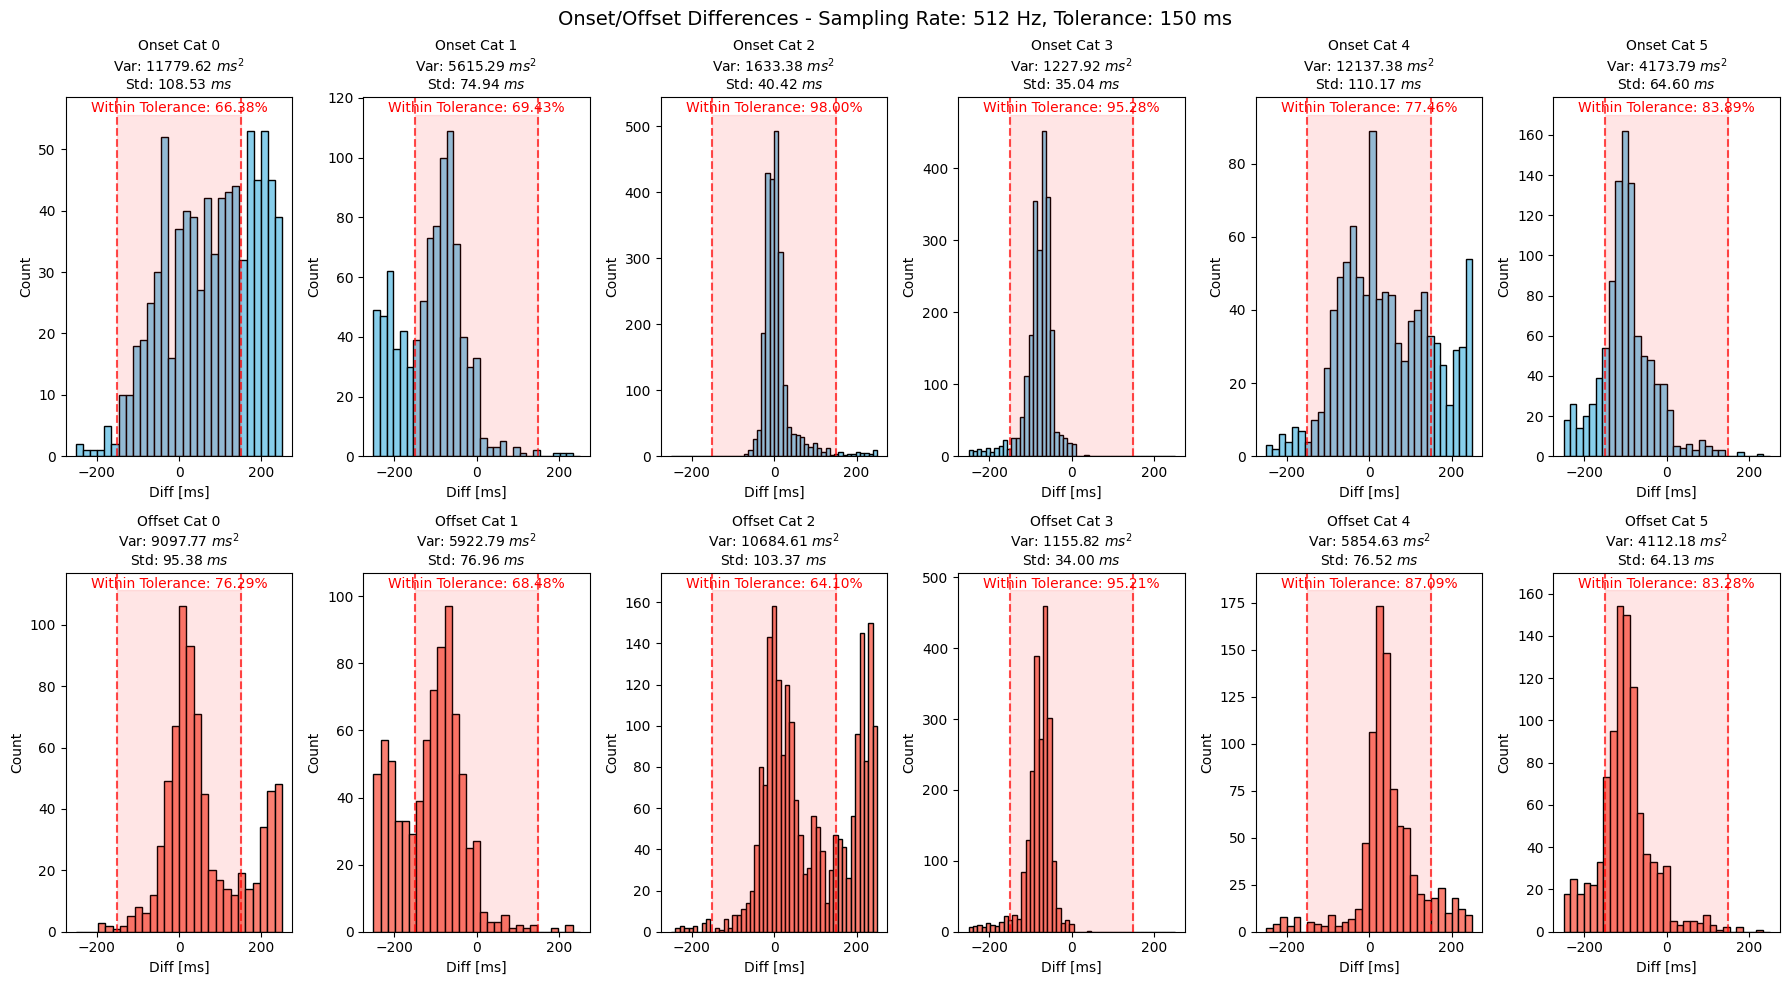

Test Epoch End
-----------------------------------
Testing DataLoader 0: 100%|██████████| 202/202 [03:54<00:00,  0.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               Test metric                             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              test_jaccard                          0.5186147093772888
             test_loss_epoch                        0.5487108826637268
     tolerance_10ms_f1_offset_global                0.09899132698774338
     tolerance_10ms_f1_onset_global                 0.17483344674110413
     tolerance_10ms_fn_offset_global                      8537.0
     tolerance_10ms_fn_onset_global                       10041.0
     tolerance_10ms_fp_offset_global                      10668.0
     tolerance_10ms_fp_onset_global                       9527.0
    tolerance_10ms_

Best trial: 0. Best value: 0.122472: 100%|██████████| 5/5 [21:54<00:00, 262.82s/it]

Best trial:  FrozenTrial(number=0, state=1, values=[0.12247161567211151], datetime_start=datetime.datetime(2025, 9, 17, 8, 56, 43, 990360), datetime_complete=datetime.datetime(2025, 9, 17, 9, 0, 30, 321130), params={'batch_size': 16, 'max_epochs': 3, 'accumulate_grad_batches': 1, 'precision': '16-mixed', 'optimizer': 'AdamW', 'learning_rate': 0.0010293490563192593, 'weight_decay': 5.0433979963289725e-05, 'scheduler': 'StepLR', 'I': 0, 'II': 0, 'III': 1, 'AVR': 1, 'AVL': 1, 'AVF': 1, 'V1': 0, 'V2': 1, 'V3': 1, 'V4': 1, 'V5': 0, 'V6': 0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'batch_size': CategoricalDistribution(choices=(16, 32, 64)), 'max_epochs': IntDistribution(high=3, log=False, low=3, step=10), 'accumulate_grad_batches': CategoricalDistribution(choices=(1, 2, 4, 8)), 'precision': CategoricalDistribution(choices=('16-mixed', 32)), 'optimizer': CategoricalDistribution(choices=('Adam', 'SGD', 'AdamW')), 'learning_rate': FloatDistribution(high=0.01, log

In [9]:
import optuna
from training.hyperparameter_optimization import OptunaTrainer

def objective(trial):
    model = UNET_1D
    config["sweep_id"] = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    config["dataset_name"] = "ECG_TEST_DATASET"
    config["model_name"] = type(model).__name__
    trainer = OptunaTrainer(
        model=model,
        config=config
    )

    # Run training and return validation loss
    val_loss = trainer.run_training(trial)

    # Run testing to save test results / metrics of trained model
    trainer.run_test()

    return val_loss

# Optuna Hyperparameter Study
study = optuna.create_study(direction="minimize", study_name=f"Optuna_HPO_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')}")

# Reduce output clutter by setting verbosity to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start optimization
study.optimize(objective, n_trials=config['number_of_trials'], gc_after_trial=True, show_progress_bar=True)

# Best result
print("Best trial: ", study.best_trial)
print("Best value (loss): ", study.best_value)